In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'CNN Time Series Experiments - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [5]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [6]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [7]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Cyclic Stocks

### Singapore Airlines

In [8]:
nr_test_sets = ['C6L.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [9]:
r_test_sets = ['C6L.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


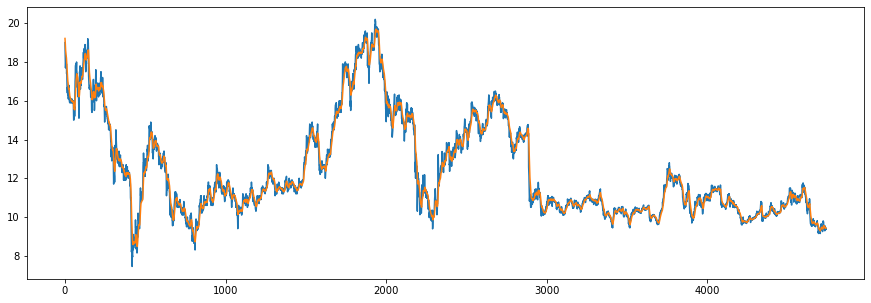

In [10]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/C6L.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 4297, 0.0: 215, 1.0: 213})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('C6L.SI')]
    y = nr_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('C6L.SI')]
    y = r_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.325581395348837, 1: 7.411764705882353, 2: 0.36649214659685864}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2186 - accuracy: 0.4439 - mse: 0.9653 - weighted_accuracy: 0.3393 - weighted_mse: 0.9933 - val_loss: 0.1897 - val_accuracy: 0.1746 - val_mse: 1.1758 - val_weighted_accuracy: 0.1746 - val_weighted_mse: 1.1758
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2032 - accuracy: 0.3167 - mse: 1.1564 - weighted_accuracy: 0.3555 - weighted_mse: 1.1692 - val_loss: 0.1928 - val_accuracy: 0.1291 - val_mse: 1.0768 - val_weighted_accuracy: 0.1291 - val_weighted_mse: 1.0768
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1981 - accuracy: 0.3045 - mse: 1.2045 - weighted_accuracy: 0.4062 - weighted_mse: 1.1865 - val_loss: 0.1954 - val_accuracy: 0.0794 - val_mse: 1.1090 - val_weighted_accuracy: 0.0794 - val_weighted_mse: 1.1090
Epoch 4/20
30/30 [==============================] - 0s 9

7/7 [==============================] - 0s 6ms/step - loss: 0.2022 - accuracy: 0.1256 - mse: 1.2903 - weighted_accuracy: 0.1256 - weighted_mse: 1.2903
Test loss: 0.20220401883125305
Test accuracy: 0.12558139860630035


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 121
actual holds but predicted sell: 65
actual predicted holds: 12
Percentage buys correct: 5.46875%
Percentage sells correct: 10.95890410958904%
Percentage holds correct: 85.71428571428571%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.09375%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from prev

Epoch 11/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1644 - accuracy: 0.2331 - mse: 1.4248 - weighted_accuracy: 0.5985 - weighted_mse: 1.3575 - val_loss: 0.1927 - val_accuracy: 0.2423 - val_mse: 1.3353 - val_weighted_accuracy: 0.2423 - val_weighted_mse: 1.3353
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1681 - accuracy: 0.2624 - mse: 1.4454 - weighted_accuracy: 0.5631 - weighted_mse: 1.3476 - val_loss: 0.1961 - val_accuracy: 0.2180 - val_mse: 1.4343 - val_weighted_accuracy: 0.2180 - val_weighted_mse: 1.4343
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1665 - accuracy: 0.2873 - mse: 1.4829 - weighted_accuracy: 0.5925 - weighted_mse: 1.4014 - val_loss: 0.1952 - val_accuracy: 0.2275 - val_mse: 1.3214 - val_weighted_accuracy: 0.2275 - val_weighted_mse: 1.3214
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1665 - accuracy: 0.2442 - mse: 1.4594 - weighted_accuracy: 0.5675 - weighte

7/7 [==============================] - 0s 2ms/step - loss: 0.1968 - accuracy: 0.1535 - mse: 1.4642 - weighted_accuracy: 0.1535 - weighted_mse: 1.4642
Test loss: 0.19680491089820862
Test accuracy: 0.1534883677959442


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 114
actual holds but predicted sell: 67
actual predicted holds: 17
Percentage buys correct: 5.785123966942149%
Percentage sells correct: 11.688311688311689%
Percentage holds correct: 100.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.107438016528924%
Percentage high sells correct: 60.526315789473685%
Percentage mid holds correct: 94.11764705882354%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase f

30/30 [==============================] - 0s 9ms/step - loss: 0.1627 - accuracy: 0.2410 - mse: 1.5390 - weighted_accuracy: 0.5941 - weighted_mse: 1.4628 - val_loss: 0.1969 - val_accuracy: 0.2074 - val_mse: 1.4055 - val_weighted_accuracy: 0.2074 - val_weighted_mse: 1.4055
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1600 - accuracy: 0.2690 - mse: 1.4975 - weighted_accuracy: 0.6082 - weighted_mse: 1.4250 - val_loss: 0.2002 - val_accuracy: 0.2190 - val_mse: 1.3628 - val_weighted_accuracy: 0.2190 - val_weighted_mse: 1.3628
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1620 - accuracy: 0.2561 - mse: 1.5204 - weighted_accuracy: 0.6106 - weighted_mse: 1.4525 - val_loss: 0.1982 - val_accuracy: 0.2222 - val_mse: 1.3422 - val_weighted_accuracy: 0.2222 - val_weighted_mse: 1.3422
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1624 - accuracy: 0.2603 - mse: 1.5098 - weighted_accuracy: 0.5790 - weighted_mse: 1.4318 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1921 - accuracy: 0.2140 - mse: 1.4800 - weighted_accuracy: 0.2140 - weighted_mse: 1.4800
Test loss: 0.19211702048778534
Test accuracy: 0.21395349502563477


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 111
actual holds but predicted sell: 57
actual predicted holds: 30
Percentage buys correct: 5.932203389830509%
Percentage sells correct: 13.636363636363637%
Percentage holds correct: 96.7741935483871%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.45762711864407%
Percentage high sells correct: 64.61538461538461%
Percentage mid holds correct: 90.3225806451613%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price i

30/30 [==============================] - 0s 9ms/step - loss: 0.1554 - accuracy: 0.2640 - mse: 1.6072 - weighted_accuracy: 0.6193 - weighted_mse: 1.5354 - val_loss: 0.1986 - val_accuracy: 0.2550 - val_mse: 1.5813 - val_weighted_accuracy: 0.2550 - val_weighted_mse: 1.5813
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1551 - accuracy: 0.2958 - mse: 1.6463 - weighted_accuracy: 0.6198 - weighted_mse: 1.6020 - val_loss: 0.2002 - val_accuracy: 0.2328 - val_mse: 1.5065 - val_weighted_accuracy: 0.2328 - val_weighted_mse: 1.5065
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1572 - accuracy: 0.2577 - mse: 1.6280 - weighted_accuracy: 0.6262 - weighted_mse: 1.5160 - val_loss: 0.1945 - val_accuracy: 0.2677 - val_mse: 1.5658 - val_weighted_accuracy: 0.2677 - val_weighted_mse: 1.5658
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1566 - accuracy: 0.2630 - mse: 1.5917 - weighted_accuracy: 0.6243 - weighted_mse: 1.5513 -

7/7 [==============================] - 0s 2ms/step - loss: 0.1961 - accuracy: 0.2047 - mse: 1.5705 - weighted_accuracy: 0.2047 - weighted_mse: 1.5705
Test loss: 0.19608697295188904
Test accuracy: 0.20465116202831268


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 109
actual holds but predicted sell: 60
actual predicted holds: 29
Percentage buys correct: 6.0344827586206895%
Percentage sells correct: 11.594202898550725%
Percentage holds correct: 96.66666666666667%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.41379310344828%
Percentage high sells correct: 61.76470588235294%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase fr

30/30 [==============================] - 0s 10ms/step - loss: 0.1517 - accuracy: 0.2807 - mse: 1.7371 - weighted_accuracy: 0.6605 - weighted_mse: 1.6391 - val_loss: 0.1975 - val_accuracy: 0.2656 - val_mse: 1.5822 - val_weighted_accuracy: 0.2656 - val_weighted_mse: 1.5822
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1495 - accuracy: 0.2741 - mse: 1.7217 - weighted_accuracy: 0.6469 - weighted_mse: 1.6630 - val_loss: 0.1984 - val_accuracy: 0.2667 - val_mse: 1.6277 - val_weighted_accuracy: 0.2667 - val_weighted_mse: 1.6277
Epoch 6/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1503 - accuracy: 0.3005 - mse: 1.6549 - weighted_accuracy: 0.6344 - weighted_mse: 1.6134 - val_loss: 0.1955 - val_accuracy: 0.2815 - val_mse: 1.5781 - val_weighted_accuracy: 0.2815 - val_weighted_mse: 1.5781
Epoch 7/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1489 - accuracy: 0.3053 - mse: 1.6642 - weighted_accuracy: 0.6583 - weighted_mse: 1.5869

7/7 [==============================] - 0s 2ms/step - loss: 0.1917 - accuracy: 0.2837 - mse: 1.7003 - weighted_accuracy: 0.2837 - weighted_mse: 1.7003
Test loss: 0.1917210966348648
Test accuracy: 0.2837209403514862


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 101
actual holds but predicted sell: 51
actual predicted holds: 46
Percentage buys correct: 6.481481481481482%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 97.87234042553192%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.148148148148145%
Percentage high sells correct: 62.71186440677966%
Percentage mid holds correct: 89.36170212765957%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price

30/30 [==============================] - 0s 9ms/step - loss: 0.1448 - accuracy: 0.3183 - mse: 1.8125 - weighted_accuracy: 0.6705 - weighted_mse: 1.7379 - val_loss: 0.2100 - val_accuracy: 0.2286 - val_mse: 1.7449 - val_weighted_accuracy: 0.2286 - val_weighted_mse: 1.7449
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1439 - accuracy: 0.3188 - mse: 1.7390 - weighted_accuracy: 0.6763 - weighted_mse: 1.6992 - val_loss: 0.1911 - val_accuracy: 0.3249 - val_mse: 1.7351 - val_weighted_accuracy: 0.3249 - val_weighted_mse: 1.7351
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1435 - accuracy: 0.3407 - mse: 1.8517 - weighted_accuracy: 0.6622 - weighted_mse: 1.8310 - val_loss: 0.1972 - val_accuracy: 0.2857 - val_mse: 1.6765 - val_weighted_accuracy: 0.2857 - val_weighted_mse: 1.6765
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1449 - accuracy: 0.3225 - mse: 1.7737 - weighted_accuracy: 0.6758 - weighted_mse: 1.7239

7/7 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.3163 - mse: 1.8108 - weighted_accuracy: 0.3163 - weighted_mse: 1.8108
Test loss: 0.19134590029716492
Test accuracy: 0.3162790834903717


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 99
actual holds but predicted sell: 45
actual predicted holds: 54
Percentage buys correct: 5.714285714285714%
Percentage sells correct: 14.814814814814815%
Percentage holds correct: 96.42857142857143%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.61904761904762%
Percentage high sells correct: 67.9245283018868%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from 

Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1397 - accuracy: 0.3521 - mse: 1.9172 - weighted_accuracy: 0.6904 - weighted_mse: 1.9069 - val_loss: 0.1913 - val_accuracy: 0.3206 - val_mse: 1.7562 - val_weighted_accuracy: 0.3206 - val_weighted_mse: 1.7562
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1376 - accuracy: 0.3503 - mse: 1.8856 - weighted_accuracy: 0.7138 - weighted_mse: 1.8684 - val_loss: 0.1896 - val_accuracy: 0.3407 - val_mse: 1.9203 - val_weighted_accuracy: 0.3407 - val_weighted_mse: 1.9203
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1391 - accuracy: 0.3889 - mse: 1.9953 - weighted_accuracy: 0.7075 - weighted_mse: 1.9781 - val_loss: 0.1887 - val_accuracy: 0.3407 - val_mse: 1.8572 - val_weighted_accuracy: 0.3407 - val_weighted_mse: 1.8572
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1365 - accuracy: 0.3712 - mse: 1.9250 - weighted_accuracy: 0.7048 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1904 - accuracy: 0.3395 - mse: 1.9029 - weighted_accuracy: 0.3395 - weighted_mse: 1.9029
Test loss: 0.19037851691246033
Test accuracy: 0.3395348787307739


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 95
actual holds but predicted sell: 43
actual predicted holds: 60
Percentage buys correct: 5.9405940594059405%
Percentage sells correct: 13.72549019607843%
Percentage holds correct: 95.23809523809524%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.51485148514851%
Percentage high sells correct: 68.0%
Percentage mid holds correct: 87.3015873015873%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from 

Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1325 - accuracy: 0.3878 - mse: 2.0558 - weighted_accuracy: 0.7183 - weighted_mse: 2.0699 - val_loss: 0.1979 - val_accuracy: 0.3291 - val_mse: 1.9872 - val_weighted_accuracy: 0.3291 - val_weighted_mse: 1.9872
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1313 - accuracy: 0.4220 - mse: 2.0881 - weighted_accuracy: 0.7288 - weighted_mse: 2.1800 - val_loss: 0.1904 - val_accuracy: 0.3587 - val_mse: 1.9488 - val_weighted_accuracy: 0.3587 - val_weighted_mse: 1.9488
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1320 - accuracy: 0.3947 - mse: 2.0716 - weighted_accuracy: 0.7153 - weighted_mse: 2.0873 - val_loss: 0.1917 - val_accuracy: 0.3608 - val_mse: 1.9211 - val_weighted_accuracy: 0.3608 - val_weighted_mse: 1.9211
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1312 - accuracy: 0.3926 - mse: 2.0273 - weighted_accuracy: 0.7164 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1882 - accuracy: 0.3814 - mse: 1.9814 - weighted_accuracy: 0.3814 - weighted_mse: 1.9814
Test loss: 0.18818144500255585
Test accuracy: 0.3813953399658203


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 90
actual holds but predicted sell: 39
actual predicted holds: 69
Percentage buys correct: 6.25%
Percentage sells correct: 14.893617021276595%
Percentage holds correct: 95.83333333333333%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 48.958333333333336%
Percentage high sells correct: 67.3913043478261%
Percentage mid holds correct: 90.27777777777777%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from

Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1249 - accuracy: 0.4651 - mse: 2.2646 - weighted_accuracy: 0.7373 - weighted_mse: 2.4217 - val_loss: 0.1868 - val_accuracy: 0.4095 - val_mse: 2.0563 - val_weighted_accuracy: 0.4095 - val_weighted_mse: 2.0563
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1272 - accuracy: 0.4447 - mse: 2.1910 - weighted_accuracy: 0.7372 - weighted_mse: 2.3130 - val_loss: 0.1860 - val_accuracy: 0.4127 - val_mse: 2.0417 - val_weighted_accuracy: 0.4127 - val_weighted_mse: 2.0417
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1257 - accuracy: 0.4360 - mse: 2.1683 - weighted_accuracy: 0.7470 - weighted_mse: 2.2557 - val_loss: 0.1902 - val_accuracy: 0.3947 - val_mse: 2.1569 - val_weighted_accuracy: 0.3947 - val_weighted_mse: 2.1569
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1228 - accuracy: 0.4685 - mse: 2.2631 - weighted_accuracy: 0.7608 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1907 - accuracy: 0.3907 - mse: 2.2246 - weighted_accuracy: 0.3907 - weighted_mse: 2.2246
Test loss: 0.1906563639640808
Test accuracy: 0.3906976878643036


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 89
actual holds but predicted sell: 38
actual predicted holds: 71
Percentage buys correct: 6.315789473684211%
Percentage sells correct: 15.217391304347826%
Percentage holds correct: 95.94594594594595%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 49.473684210526315%
Percentage high sells correct: 66.66666666666667%
Percentage mid holds correct: 90.54054054054055%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price 

Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1198 - accuracy: 0.5069 - mse: 2.4104 - weighted_accuracy: 0.7545 - weighted_mse: 2.5538 - val_loss: 0.1732 - val_accuracy: 0.4963 - val_mse: 2.2815 - val_weighted_accuracy: 0.4963 - val_weighted_mse: 2.2815
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1207 - accuracy: 0.5063 - mse: 2.3824 - weighted_accuracy: 0.7561 - weighted_mse: 2.5925 - val_loss: 0.1784 - val_accuracy: 0.4571 - val_mse: 2.2264 - val_weighted_accuracy: 0.4571 - val_weighted_mse: 2.2264
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1186 - accuracy: 0.4775 - mse: 2.3114 - weighted_accuracy: 0.7677 - weighted_mse: 2.5266 - val_loss: 0.1788 - val_accuracy: 0.4571 - val_mse: 2.2172 - val_weighted_accuracy: 0.4571 - val_weighted_mse: 2.2172
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1173 - accuracy: 0.5079 - mse: 2.4157 - weighted_accuracy: 0.7845 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1811 - accuracy: 0.4558 - mse: 2.3435 - weighted_accuracy: 0.4558 - weighted_mse: 2.3435
Test loss: 0.1810961365699768
Test accuracy: 0.4558139443397522


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 4
actual holds but predicted buy: 79
actual holds but predicted sell: 32
actual predicted holds: 87
Percentage buys correct: 7.0588235294117645%
Percentage sells correct: 13.157894736842104%
Percentage holds correct: 94.56521739130434%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 50.588235294117645%
Percentage high sells correct: 70.27027027027027%
Percentage mid holds correct: 88.04347826086956%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price

In [17]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.125581,5.468750,10.958904,85.714286,46.093750,58.333333,85.714286,-85.897172,-78.238355
1,0.153488,5.785124,11.688312,100.000000,47.107438,60.526316,94.117647,-87.980622,-78.238355
2,0.213953,5.932203,13.636364,96.774194,47.457627,64.615385,90.322581,-85.397410,-78.238355
3,0.204651,6.034483,11.594203,96.666667,47.413793,61.764706,90.000000,-89.326832,-78.238355
4,0.283721,6.481481,13.333333,97.872340,48.148148,62.711864,89.361702,-85.227351,-78.238355
5,0.316279,5.714286,14.814815,96.428571,47.619048,67.924528,87.500000,-81.968761,-78.238355
6,0.339535,5.940594,13.725490,95.238095,48.514851,68.000000,87.301587,-83.141752,-78.238355
7,0.381395,6.250000,14.893617,95.833333,48.958333,67.391304,90.277778,-84.498858,-78.238355
8,0.390698,6.315789,15.217391,95.945946,49.473684,66.666667,90.540541,-83.237900,-78.238355
9,0.455814,7.058824,13.157895,94.565217,50.588235,70.270270,88.043478,-89.291689,-78.238355


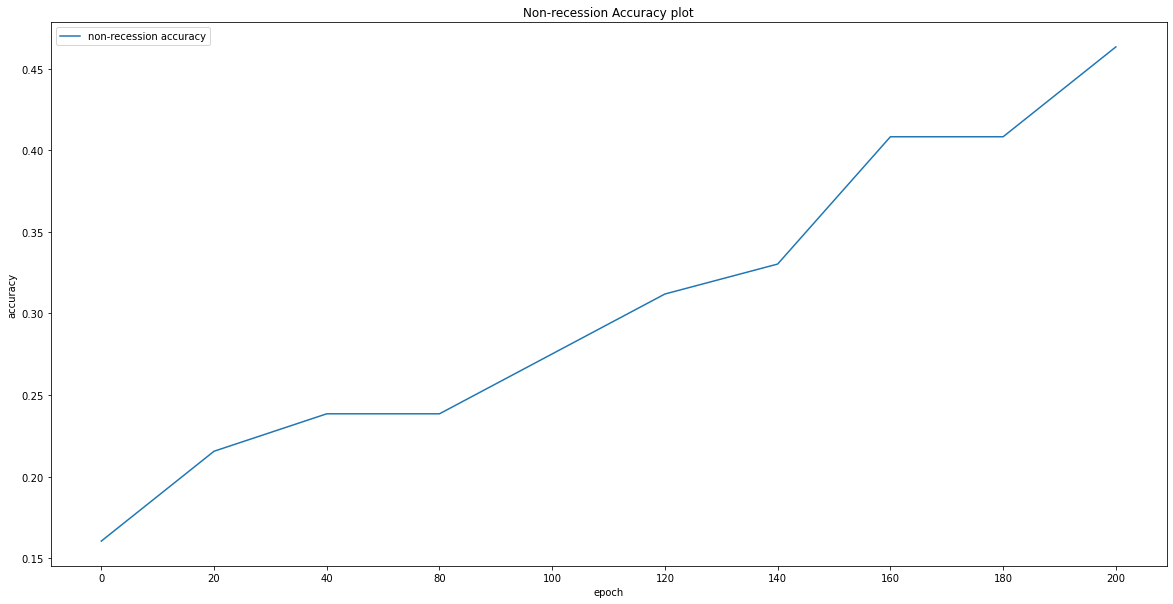

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

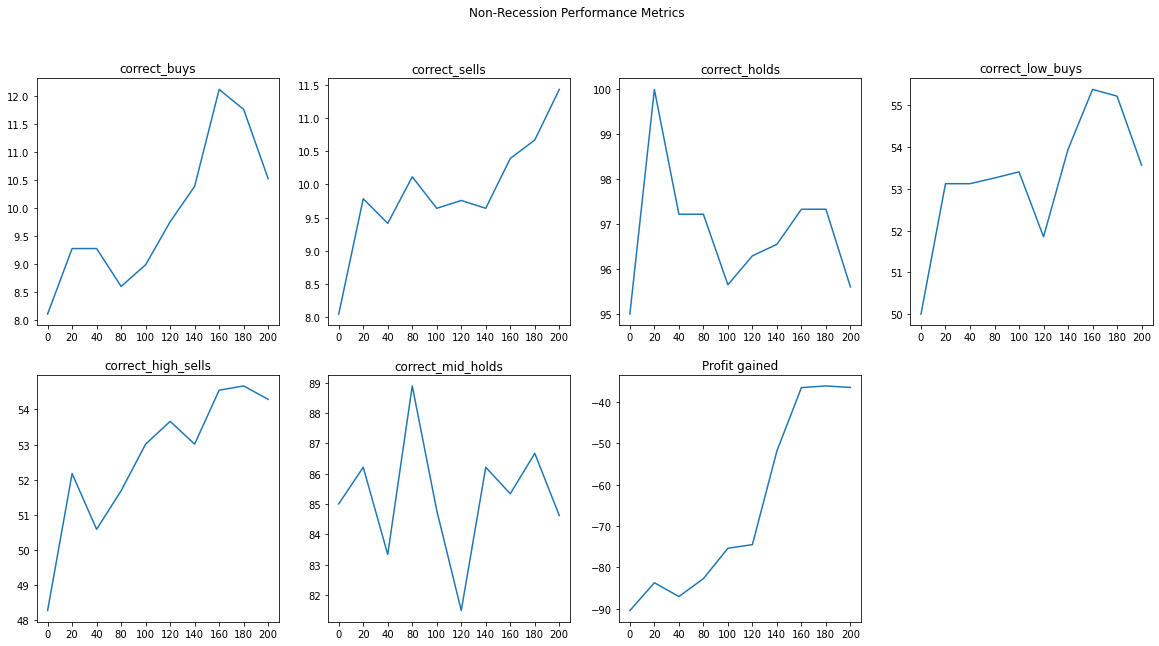

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

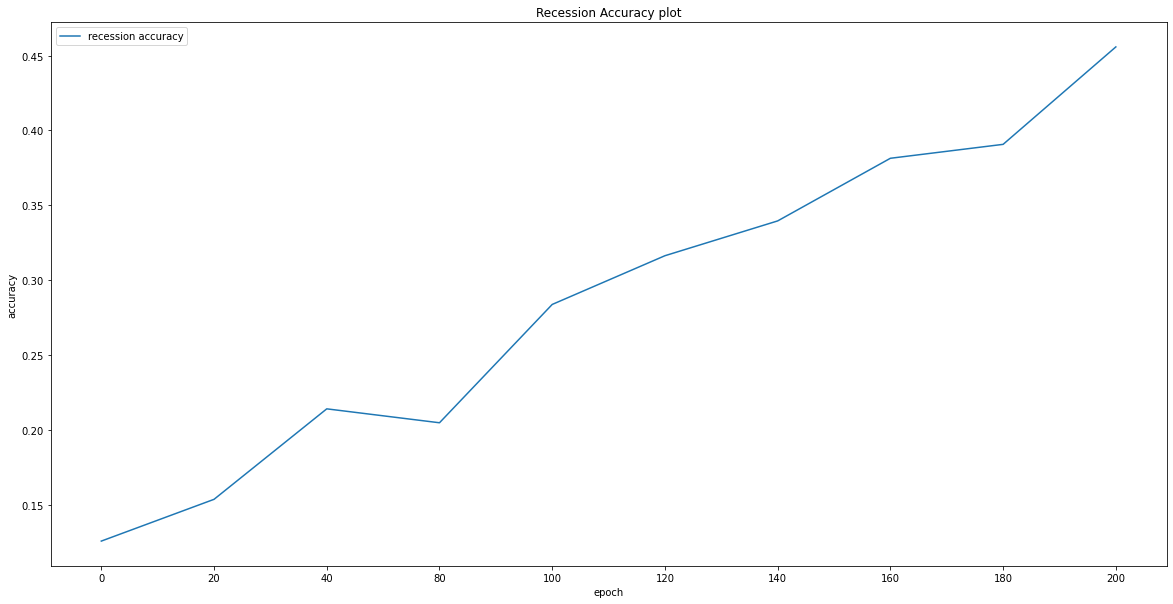

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

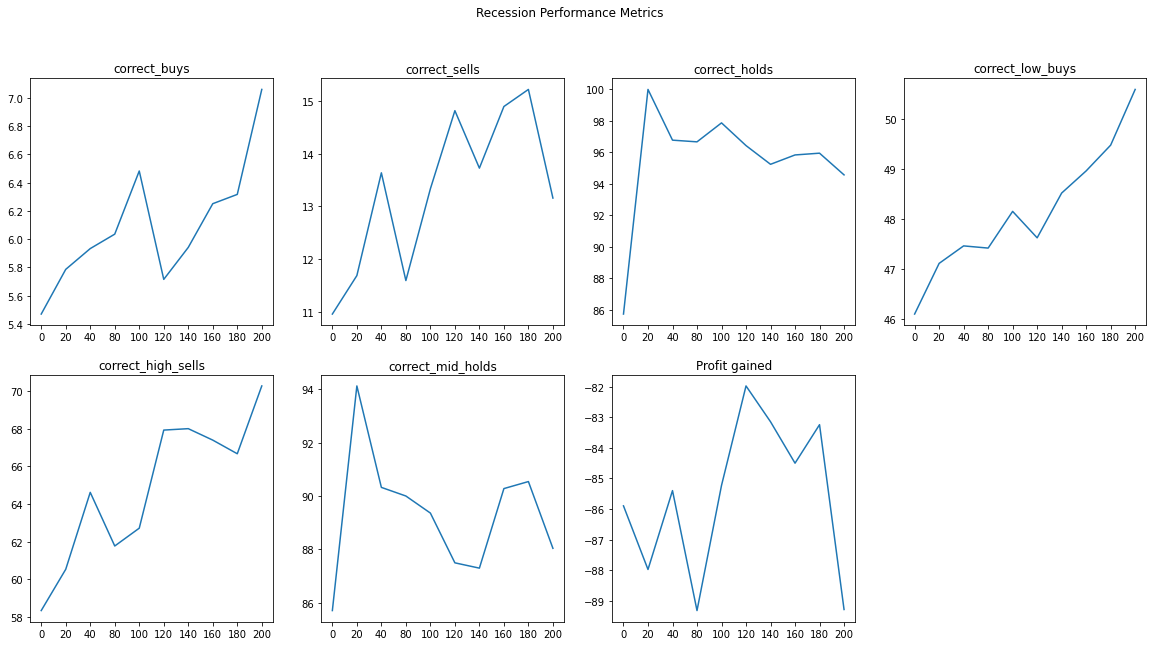

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### OCBC Bank

In [22]:
nr_test_sets = ['O39.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


In [23]:
r_test_sets = ['O39.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


### training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


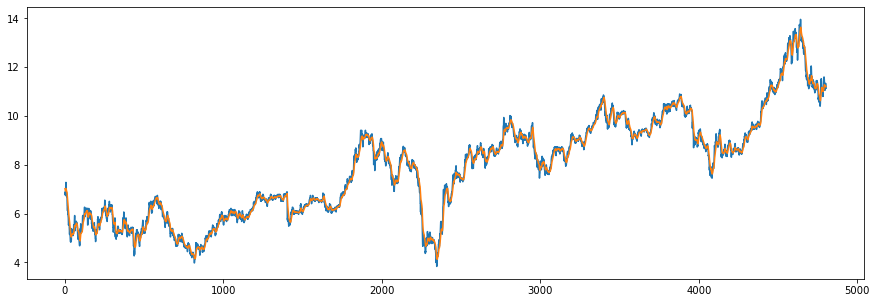

In [24]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/O39.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('O39.SI')]
    y = nr_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('O39.SI')]
    y = r_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.255681818181818, 1: 7.931677018633541, 2: 0.3654836863194047}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2169 - accuracy: 0.3892 - mse: 0.9855 - weighted_accuracy: 0.3428 - weighted_mse: 1.0254 - val_loss: 0.1925 - val_accuracy: 0.1576 - val_mse: 1.1349 - val_weighted_accuracy: 0.1576 - val_weighted_mse: 1.1349
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2008 - accuracy: 0.3125 - mse: 1.1449 - weighted_accuracy: 0.3897 - weighted_mse: 1.1410 - val_loss: 0.1920 - val_accuracy: 0.1514 - val_mse: 1.1443 - val_weighted_accuracy: 0.1514 - val_weighted_mse: 1.1443
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1992 - accuracy: 0.3279 - mse: 1.1764 - weighted_accuracy: 0.4204 - weighted_mse: 1.1774 - val_loss: 0.1923 - val_accuracy: 0.1775 - val_mse: 1.0742 - val_weighted_accuracy: 0.1775 - val_weighted_mse: 1.0742
Epoch 4/20
30/30 [==============================] - 0s 9m

7/7 [==============================] - 0s 2ms/step - loss: 0.2073 - accuracy: 0.1535 - mse: 1.3601 - weighted_accuracy: 0.1535 - weighted_mse: 1.3601
Test loss: 0.2073403000831604
Test accuracy: 0.1534883677959442


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 0
actual holds but predicted buy: 92
actual holds but predicted sell: 85
actual predicted holds: 16
Percentage buys correct: 7.920792079207921%
Percentage sells correct: 9.278350515463918%
Percentage holds correct: 94.11764705882354%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.475247524752476%
Percentage high sells correct: 55.208333333333336%
Percentage mid holds correct: 88.23529411764706%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price

Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1611 - accuracy: 0.2665 - mse: 1.5991 - weighted_accuracy: 0.6002 - weighted_mse: 1.5031 - val_loss: 0.2018 - val_accuracy: 0.2067 - val_mse: 1.5000 - val_weighted_accuracy: 0.2067 - val_weighted_mse: 1.5000
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1604 - accuracy: 0.2608 - mse: 1.5847 - weighted_accuracy: 0.5995 - weighted_mse: 1.4899 - val_loss: 0.2056 - val_accuracy: 0.1837 - val_mse: 1.3693 - val_weighted_accuracy: 0.1837 - val_weighted_mse: 1.3693
Epoch 15/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1599 - accuracy: 0.2415 - mse: 1.5593 - weighted_accuracy: 0.6180 - weighted_mse: 1.4746 - val_loss: 0.2020 - val_accuracy: 0.2067 - val_mse: 1.5062 - val_weighted_accuracy: 0.2067 - val_weighted_mse: 1.5062
Epoch 16/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1596 - accuracy: 0.2803 - mse: 1.6135 - weighted_accuracy: 0.6158 - weighted


RUNNING EPOCHS 40 - 60



Epoch 1/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1565 - accuracy: 0.2412 - mse: 1.6553 - weighted_accuracy: 0.6156 - weighted_mse: 1.5557 - val_loss: 0.2053 - val_accuracy: 0.2056 - val_mse: 1.5176 - val_weighted_accuracy: 0.2056 - val_weighted_mse: 1.5176
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1560 - accuracy: 0.2456 - mse: 1.6749 - weighted_accuracy: 0.6177 - weighted_mse: 1.5614 - val_loss: 0.2016 - val_accuracy: 0.2150 - val_mse: 1.5817 - val_weighted_accuracy: 0.2150 - val_weighted_mse: 1.5817
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1569 - accuracy: 0.2485 - mse: 1.6858 - weighted_accuracy: 0.6288 - weighted_mse: 1.5722 - val_loss: 0.2038 - val_accuracy: 0.1900 - val_mse: 1.5802 - val_weighted_accuracy: 0.1900 - val_weighted_mse: 1.5802
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1538 - accuracy: 0.2461 - mse: 1.7233 - weighted_accu

7/7 [==============================] - 0s 2ms/step - loss: 0.2087 - accuracy: 0.2000 - mse: 1.7718 - weighted_accuracy: 0.2000 - weighted_mse: 1.7718
Test loss: 0.2086818665266037
Test accuracy: 0.20000000298023224


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 87
actual holds but predicted sell: 77
actual predicted holds: 29
Percentage buys correct: 7.368421052631579%
Percentage sells correct: 8.045977011494253%
Percentage holds correct: 87.87878787878788%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 50.526315789473685%
Percentage high sells correct: 56.97674418604651%
Percentage mid holds correct: 87.87878787878788%


Capital: 100
Share price: $0.9886586309918834
Shares owned at the moment: 100
Cash capital at the moment: $0.8622557772888797


Price

30/30 [==============================] - 0s 9ms/step - loss: 0.1478 - accuracy: 0.2840 - mse: 1.8215 - weighted_accuracy: 0.6529 - weighted_mse: 1.7434 - val_loss: 0.2014 - val_accuracy: 0.2234 - val_mse: 1.7772 - val_weighted_accuracy: 0.2234 - val_weighted_mse: 1.7772
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1476 - accuracy: 0.2929 - mse: 1.9185 - weighted_accuracy: 0.6529 - weighted_mse: 1.8173 - val_loss: 0.2015 - val_accuracy: 0.2349 - val_mse: 1.7732 - val_weighted_accuracy: 0.2349 - val_weighted_mse: 1.7732
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1465 - accuracy: 0.2673 - mse: 1.9128 - weighted_accuracy: 0.6594 - weighted_mse: 1.8324 - val_loss: 0.1947 - val_accuracy: 0.2745 - val_mse: 1.8262 - val_weighted_accuracy: 0.2745 - val_weighted_mse: 1.8262
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1464 - accuracy: 0.2694 - mse: 1.8918 - weighted_accuracy: 0.6627 - weighted_mse: 1.7916

7/7 [==============================] - 0s 2ms/step - loss: 0.2129 - accuracy: 0.2186 - mse: 1.9532 - weighted_accuracy: 0.2186 - weighted_mse: 1.9532
Test loss: 0.2128802090883255
Test accuracy: 0.2186046540737152


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 1
actual holds but predicted buy: 82
actual holds but predicted sell: 79
actual predicted holds: 32
Percentage buys correct: 7.777777777777778%
Percentage sells correct: 8.88888888888889%
Percentage holds correct: 91.42857142857143%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.22222222222222%
Percentage high sells correct: 57.30337078651685%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price in

Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1413 - accuracy: 0.3294 - mse: 2.0224 - weighted_accuracy: 0.7023 - weighted_mse: 1.9110 - val_loss: 0.1955 - val_accuracy: 0.2745 - val_mse: 1.8895 - val_weighted_accuracy: 0.2745 - val_weighted_mse: 1.8895
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1420 - accuracy: 0.3164 - mse: 1.9744 - weighted_accuracy: 0.6908 - weighted_mse: 1.9103 - val_loss: 0.1911 - val_accuracy: 0.3163 - val_mse: 1.8496 - val_weighted_accuracy: 0.3163 - val_weighted_mse: 1.8496
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1434 - accuracy: 0.3007 - mse: 2.0068 - weighted_accuracy: 0.6680 - weighted_mse: 1.9661 - val_loss: 0.1965 - val_accuracy: 0.2756 - val_mse: 1.8890 - val_weighted_accuracy: 0.2756 - val_weighted_mse: 1.8890
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1430 - accuracy: 0.3072 - mse: 2.0313 - weighted_accuracy: 0.6586 - weighted

0         -55.902029  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2071 - accuracy: 0.2651 - mse: 2.1048 - weighted_accuracy: 0.2651 - weighted_mse: 2.1048
Test loss: 0.20712672173976898
Test accuracy: 0.26511627435684204


number of predictions: 215
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 80
actual holds but predicted sell: 70
actual predicted holds: 43
Percentage buys correct: 7.954545454545454%
Percentage sells correct: 8.75%
Percentage holds correct: 91.48936170212765%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 52.27272727272727%
Percentage high sells correct: 59.49367088607595%
Percentage mid holds correct: 87.23404255319149%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment

30/30 [==============================] - 0s 8ms/step - loss: 0.1360 - accuracy: 0.3399 - mse: 2.1049 - weighted_accuracy: 0.7174 - weighted_mse: 2.0238 - val_loss: 0.1920 - val_accuracy: 0.3278 - val_mse: 2.0405 - val_weighted_accuracy: 0.3278 - val_weighted_mse: 2.0405
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1369 - accuracy: 0.3221 - mse: 2.1926 - weighted_accuracy: 0.7001 - weighted_mse: 2.0978 - val_loss: 0.1904 - val_accuracy: 0.3299 - val_mse: 2.0301 - val_weighted_accuracy: 0.3299 - val_weighted_mse: 2.0301
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1354 - accuracy: 0.3748 - mse: 2.1354 - weighted_accuracy: 0.6996 - weighted_mse: 2.1348 - val_loss: 0.1990 - val_accuracy: 0.2850 - val_mse: 1.9650 - val_weighted_accuracy: 0.2850 - val_weighted_mse: 1.9650
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1332 - accuracy: 0.3793 - mse: 2.1689 - weighted_accuracy: 0.7208 - weighted_mse: 2.1455

7/7 [==============================] - 0s 2ms/step - loss: 0.2137 - accuracy: 0.2465 - mse: 2.1528 - weighted_accuracy: 0.2465 - weighted_mse: 2.1528
Test loss: 0.2137371152639389
Test accuracy: 0.24651162326335907


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 4
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 85
actual holds but predicted sell: 70
actual predicted holds: 38
Percentage buys correct: 8.51063829787234%
Percentage sells correct: 8.641975308641975%
Percentage holds correct: 95.0%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.191489361702125%
Percentage high sells correct: 57.5%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bought: -65.24

30/30 [==============================] - 0s 10ms/step - loss: 0.1310 - accuracy: 0.3733 - mse: 2.3038 - weighted_accuracy: 0.7150 - weighted_mse: 2.2743 - val_loss: 0.1768 - val_accuracy: 0.4061 - val_mse: 2.2341 - val_weighted_accuracy: 0.4061 - val_weighted_mse: 2.2341
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1316 - accuracy: 0.3921 - mse: 2.3172 - weighted_accuracy: 0.7104 - weighted_mse: 2.3104 - val_loss: 0.1983 - val_accuracy: 0.3205 - val_mse: 2.1724 - val_weighted_accuracy: 0.3205 - val_weighted_mse: 2.1724
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1311 - accuracy: 0.4103 - mse: 2.2987 - weighted_accuracy: 0.7399 - weighted_mse: 2.2646 - val_loss: 0.1999 - val_accuracy: 0.3027 - val_mse: 2.1597 - val_weighted_accuracy: 0.3027 - val_weighted_mse: 2.1597
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1325 - accuracy: 0.3662 - mse: 2.2714 - weighted_accuracy: 0.7233 - weighted_mse: 2.2159

0         -55.902029  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2030 - accuracy: 0.2977 - mse: 2.3647 - weighted_accuracy: 0.2977 - weighted_mse: 2.3647
Test loss: 0.20302985608577728
Test accuracy: 0.29767441749572754


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 80
actual holds but predicted sell: 63
actual predicted holds: 50
Percentage buys correct: 8.98876404494382%
Percentage sells correct: 8.450704225352112%
Percentage holds correct: 90.9090909090909%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.93258426966292%
Percentage high sells correct: 55.714285714285715%
Percentage mid holds correct: 85.45454545454545%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital a

30/30 [==============================] - 0s 9ms/step - loss: 0.1268 - accuracy: 0.4176 - mse: 2.4408 - weighted_accuracy: 0.7426 - weighted_mse: 2.4317 - val_loss: 0.1945 - val_accuracy: 0.3580 - val_mse: 2.3030 - val_weighted_accuracy: 0.3580 - val_weighted_mse: 2.3030
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1252 - accuracy: 0.4466 - mse: 2.4658 - weighted_accuracy: 0.7530 - weighted_mse: 2.5168 - val_loss: 0.1996 - val_accuracy: 0.3288 - val_mse: 2.3572 - val_weighted_accuracy: 0.3288 - val_weighted_mse: 2.3572
Epoch 11/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1264 - accuracy: 0.4197 - mse: 2.4406 - weighted_accuracy: 0.7478 - weighted_mse: 2.4367 - val_loss: 0.1947 - val_accuracy: 0.3518 - val_mse: 2.3213 - val_weighted_accuracy: 0.3518 - val_weighted_mse: 2.3213
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1264 - accuracy: 0.4344 - mse: 2.4897 - weighted_accuracy: 0.7375 - weighted_mse: 2.4630

7/7 [==============================] - 0s 2ms/step - loss: 0.1996 - accuracy: 0.3395 - mse: 2.5279 - weighted_accuracy: 0.3395 - weighted_mse: 2.5279
Test loss: 0.19959229230880737
Test accuracy: 0.3395348787307739


number of predictions: 215
actual predicted buys: 8
actual buys but predicted sell: 2
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 77
actual holds but predicted sell: 57
actual predicted holds: 59
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 9.23076923076923%
Percentage holds correct: 92.1875%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.48837209302326%
Percentage high sells correct: 53.125%
Percentage mid holds correct: 87.5%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bought: -65

30/30 [==============================] - 0s 8ms/step - loss: 0.1210 - accuracy: 0.4576 - mse: 2.6113 - weighted_accuracy: 0.7645 - weighted_mse: 2.6194 - val_loss: 0.1958 - val_accuracy: 0.3633 - val_mse: 2.5000 - val_weighted_accuracy: 0.3633 - val_weighted_mse: 2.5000
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1209 - accuracy: 0.4597 - mse: 2.5927 - weighted_accuracy: 0.7655 - weighted_mse: 2.6763 - val_loss: 0.1862 - val_accuracy: 0.4040 - val_mse: 2.5100 - val_weighted_accuracy: 0.4040 - val_weighted_mse: 2.5100
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1190 - accuracy: 0.4790 - mse: 2.7084 - weighted_accuracy: 0.7609 - weighted_mse: 2.7989 - val_loss: 0.1847 - val_accuracy: 0.4154 - val_mse: 2.5694 - val_weighted_accuracy: 0.4154 - val_weighted_mse: 2.5694
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1193 - accuracy: 0.4756 - mse: 2.7165 - weighted_accuracy: 0.7731 - weighted_mse: 2.7641

7/7 [==============================] - 0s 2ms/step - loss: 0.1792 - accuracy: 0.4791 - mse: 2.7947 - weighted_accuracy: 0.4791 - weighted_mse: 2.7947
Test loss: 0.1791820228099823
Test accuracy: 0.4790697693824768


number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 57
actual holds but predicted sell: 44
actual predicted holds: 92
Percentage buys correct: 7.936507936507937%
Percentage sells correct: 11.538461538461538%
Percentage holds correct: 92.0%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 53.96825396825397%
Percentage high sells correct: 54.90196078431372%
Percentage mid holds correct: 88.0%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously b

30/30 [==============================] - 0s 8ms/step - loss: 0.1125 - accuracy: 0.5155 - mse: 2.9225 - weighted_accuracy: 0.7965 - weighted_mse: 3.0650 - val_loss: 0.1779 - val_accuracy: 0.4687 - val_mse: 2.7674 - val_weighted_accuracy: 0.4687 - val_weighted_mse: 2.7674
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1112 - accuracy: 0.5181 - mse: 2.9707 - weighted_accuracy: 0.8000 - weighted_mse: 3.0456 - val_loss: 0.1506 - val_accuracy: 0.5678 - val_mse: 2.7120 - val_weighted_accuracy: 0.5678 - val_weighted_mse: 2.7120
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1145 - accuracy: 0.5236 - mse: 2.9536 - weighted_accuracy: 0.7698 - weighted_mse: 3.0843 - val_loss: 0.1775 - val_accuracy: 0.4666 - val_mse: 2.7047 - val_weighted_accuracy: 0.4666 - val_weighted_mse: 2.7047
Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1127 - accuracy: 0.5260 - mse: 2.9381 - weighted_accuracy: 0.7908 - weighted_mse: 3.0985

0          -24.56292  


In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.153488,7.920792,9.278351,94.117647,52.475248,55.208333,88.235294,-8.626881,-24.56292
1,0.186047,7.526882,9.278351,96.000000,51.612903,56.250000,92.000000,-26.135685,-24.56292
2,0.200000,7.368421,8.045977,87.878788,50.526316,56.976744,87.878788,-51.192387,-24.56292
3,0.218605,7.777778,8.888889,91.428571,52.222222,57.303371,85.714286,-63.219718,-24.56292
4,0.265116,7.954545,8.750000,91.489362,52.272727,59.493671,87.234043,-57.634718,-24.56292
5,0.246512,8.510638,8.641975,95.000000,53.191489,57.500000,90.000000,-61.485313,-24.56292
6,0.297674,8.988764,8.450704,90.909091,53.932584,55.714286,85.454545,-60.032998,-24.56292
7,0.339535,9.302326,9.230769,92.187500,53.488372,53.125000,87.500000,-52.762905,-24.56292
8,0.479070,7.936508,11.538462,92.000000,53.968254,54.901961,88.000000,-23.330284,-24.56292
9,0.544186,7.547170,13.043478,92.241379,58.490566,55.555556,88.793103,-20.702459,-24.56292


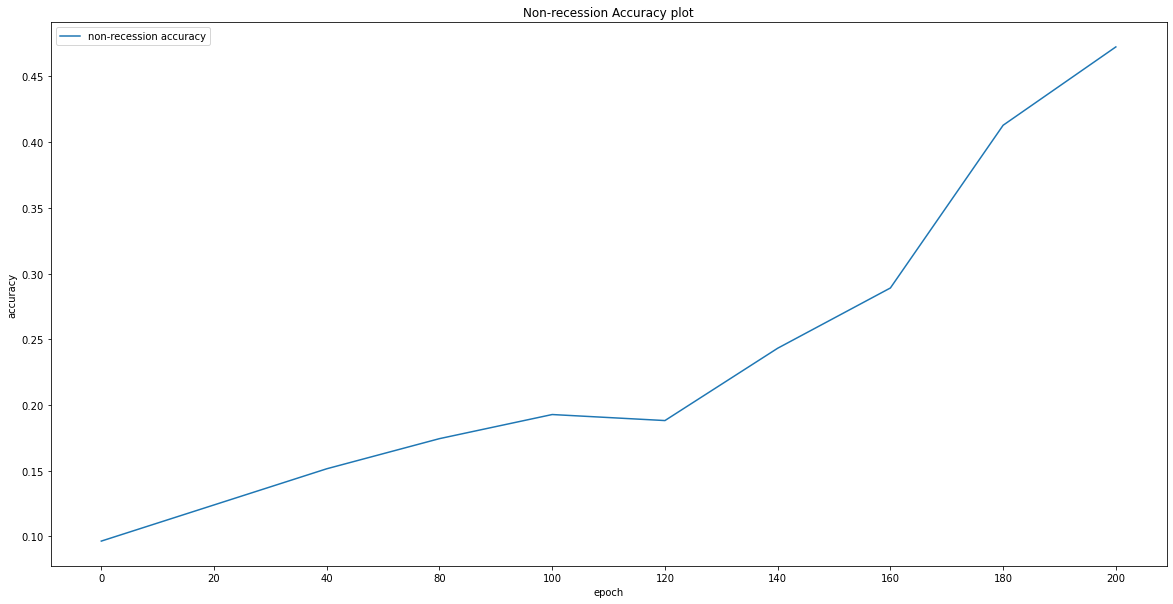

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

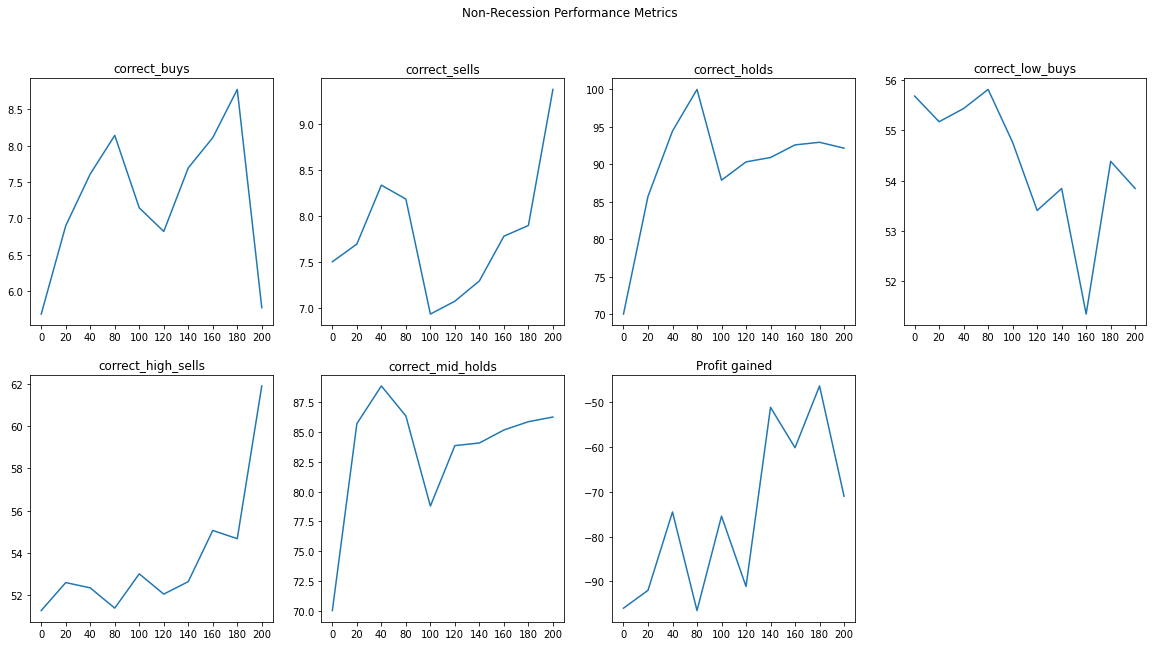

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

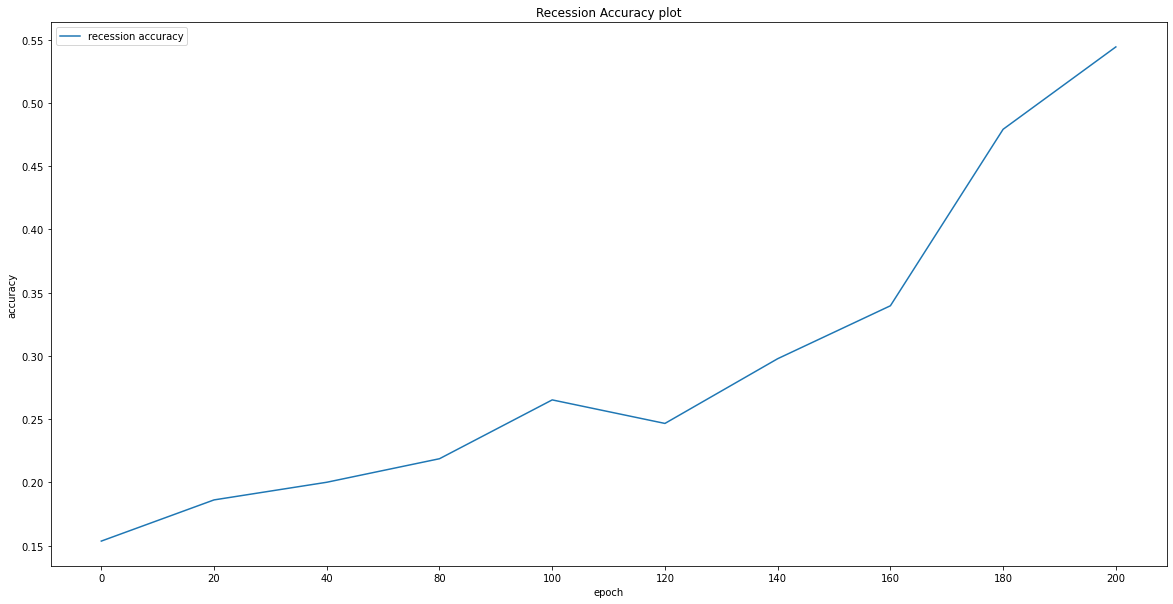

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

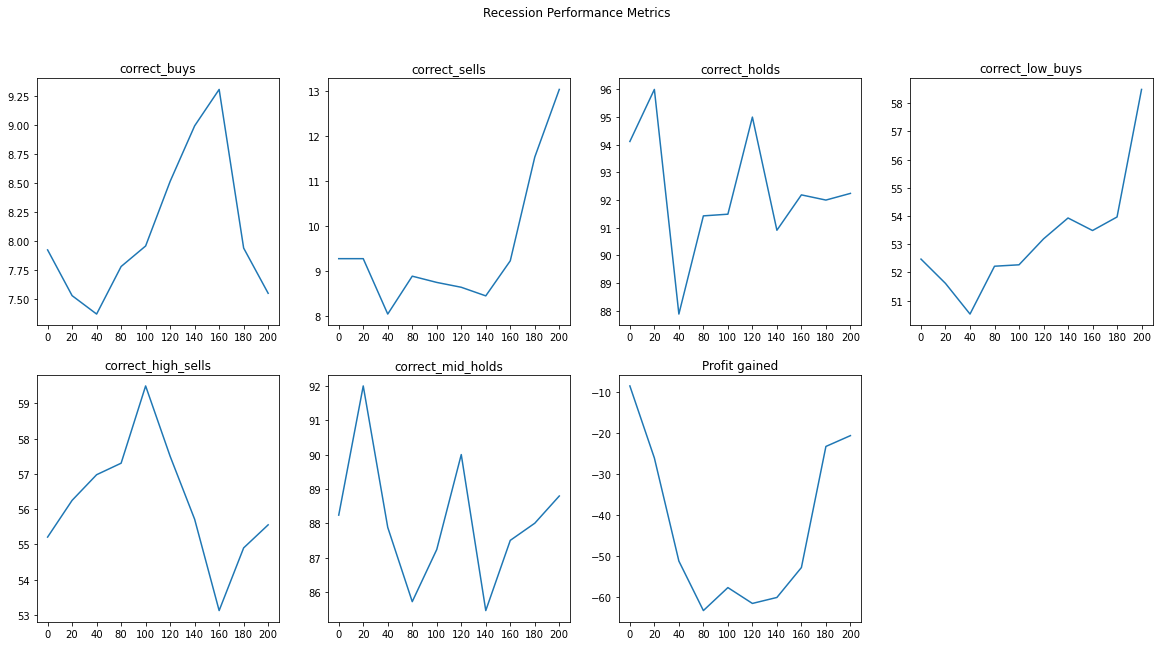

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### CNOOC Limited

In [35]:
nr_test_sets = ['0883.HK']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


In [36]:
r_test_sets = ['0883.HK']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


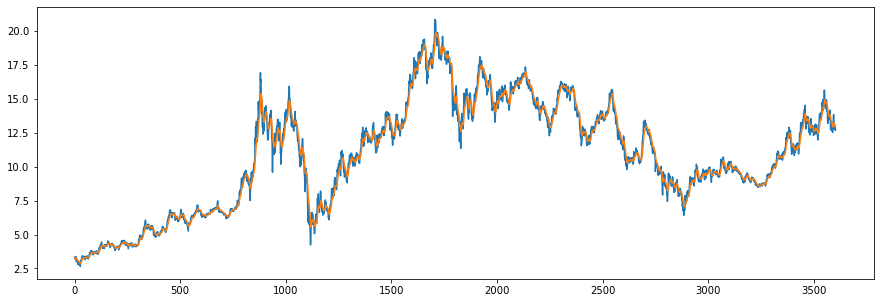

In [37]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/0883.HK_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [38]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [39]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [40]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [42]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('0883.HK')]
    y = nr_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('0883.HK')]
    y = r_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.252525252525253, 1: 7.364102564102564, 2: 0.36679438058748404}



RUNNING EPOCHS 0 - 20



Epoch 1/20
23/23 [==============================] - 1s 29ms/step - loss: 0.2254 - accuracy: 0.4265 - mse: 0.8833 - weighted_accuracy: 0.3000 - weighted_mse: 0.9221 - val_loss: 0.1887 - val_accuracy: 0.1323 - val_mse: 1.1527 - val_weighted_accuracy: 0.1323 - val_weighted_mse: 1.1527
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.2023 - accuracy: 0.4029 - mse: 1.1942 - weighted_accuracy: 0.3653 - weighted_mse: 1.2057 - val_loss: 0.1870 - val_accuracy: 0.5780 - val_mse: 1.0542 - val_weighted_accuracy: 0.5780 - val_weighted_mse: 1.0542
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1998 - accuracy: 0.3565 - mse: 1.1416 - weighted_accuracy: 0.4069 - weighted_mse: 1.1514 - val_loss: 0.1858 - val_accuracy: 0.4499 - val_mse: 1.0895 - val_weighted_accuracy: 0.4499 - val_weighted_mse: 1.0895
Epoch 4/20
23/23 [==============================] - 0s 9

7/7 [==============================] - 0s 6ms/step - loss: 0.2072 - accuracy: 0.1080 - mse: 1.2475 - weighted_accuracy: 0.1080 - weighted_mse: 1.2475
Test loss: 0.20723120868206024
Test accuracy: 0.10798121988773346


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 105
actual holds but predicted sell: 80
actual predicted holds: 8
Percentage buys correct: 6.140350877192983%
Percentage sells correct: 8.791208791208792%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 47.36842105263158%
Percentage high sells correct: 52.22222222222222%
Percentage mid holds correct: 100.0%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previous

23/23 [==============================] - 0s 9ms/step - loss: 0.1628 - accuracy: 0.2385 - mse: 1.4477 - weighted_accuracy: 0.6073 - weighted_mse: 1.3760 - val_loss: 0.2053 - val_accuracy: 0.1978 - val_mse: 1.3781 - val_weighted_accuracy: 0.1978 - val_weighted_mse: 1.3781
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1647 - accuracy: 0.2437 - mse: 1.4679 - weighted_accuracy: 0.6020 - weighted_mse: 1.3964 - val_loss: 0.1967 - val_accuracy: 0.2521 - val_mse: 1.3773 - val_weighted_accuracy: 0.2521 - val_weighted_mse: 1.3773
Epoch 13/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1642 - accuracy: 0.2991 - mse: 1.4767 - weighted_accuracy: 0.5859 - weighted_mse: 1.4024 - val_loss: 0.1959 - val_accuracy: 0.2382 - val_mse: 1.4242 - val_weighted_accuracy: 0.2382 - val_weighted_mse: 1.4242
Epoch 14/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1623 - accuracy: 0.2556 - mse: 1.5208 - weighted_accuracy: 0.5992 - weighted_mse: 1.406

7/7 [==============================] - 0s 2ms/step - loss: 0.2087 - accuracy: 0.1784 - mse: 1.4810 - weighted_accuracy: 0.1784 - weighted_mse: 1.4810
Test loss: 0.20871619880199432
Test accuracy: 0.17840375006198883


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 91
actual holds but predicted sell: 79
actual predicted holds: 23
Percentage buys correct: 7.0%
Percentage sells correct: 8.88888888888889%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.0%
Percentage high sells correct: 53.93258426966292%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.9662289181183106
Shares owned at the moment: 103
Cash capital at the moment: $0.20473709275698582


Price increase from previously bought: 1.4633

23/23 [==============================] - 0s 9ms/step - loss: 0.1544 - accuracy: 0.2594 - mse: 1.6487 - weighted_accuracy: 0.6415 - weighted_mse: 1.5352 - val_loss: 0.2000 - val_accuracy: 0.2284 - val_mse: 1.4898 - val_weighted_accuracy: 0.2284 - val_weighted_mse: 1.4898
Epoch 11/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1589 - accuracy: 0.2928 - mse: 1.5943 - weighted_accuracy: 0.5959 - weighted_mse: 1.4947 - val_loss: 0.2009 - val_accuracy: 0.2228 - val_mse: 1.4971 - val_weighted_accuracy: 0.2228 - val_weighted_mse: 1.4971
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1540 - accuracy: 0.2594 - mse: 1.6021 - weighted_accuracy: 0.6343 - weighted_mse: 1.5206 - val_loss: 0.2052 - val_accuracy: 0.2159 - val_mse: 1.5875 - val_weighted_accuracy: 0.2159 - val_weighted_mse: 1.5875
Epoch 13/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1585 - accuracy: 0.2827 - mse: 1.6338 - weighted_accuracy: 0.6211 - weighted_mse: 1.5657

7/7 [==============================] - 0s 2ms/step - loss: 0.2077 - accuracy: 0.2347 - mse: 1.5776 - weighted_accuracy: 0.2347 - weighted_mse: 1.5776
Test loss: 0.20773181319236755
Test accuracy: 0.23474177718162537


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 82
actual holds but predicted sell: 76
actual predicted holds: 35
Percentage buys correct: 7.6923076923076925%
Percentage sells correct: 9.195402298850574%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.35164835164835%
Percentage high sells correct: 53.48837209302326%
Percentage mid holds correct: 85.71428571428571%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Price increase f

Epoch 10/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1508 - accuracy: 0.2852 - mse: 1.7636 - weighted_accuracy: 0.6341 - weighted_mse: 1.6599 - val_loss: 0.1932 - val_accuracy: 0.2869 - val_mse: 1.6566 - val_weighted_accuracy: 0.2869 - val_weighted_mse: 1.6566
Epoch 11/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1487 - accuracy: 0.3200 - mse: 1.7190 - weighted_accuracy: 0.6662 - weighted_mse: 1.6522 - val_loss: 0.2009 - val_accuracy: 0.2382 - val_mse: 1.6367 - val_weighted_accuracy: 0.2382 - val_weighted_mse: 1.6367
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1509 - accuracy: 0.2942 - mse: 1.7380 - weighted_accuracy: 0.6519 - weighted_mse: 1.6671 - val_loss: 0.2002 - val_accuracy: 0.2563 - val_mse: 1.6481 - val_weighted_accuracy: 0.2563 - val_weighted_mse: 1.6481
Epoch 13/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1492 - accuracy: 0.3123 - mse: 1.7607 - weighted_accuracy: 0.6512 - weighted



Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2079 - accuracy: 0.2394 - mse: 1.6745 - weighted_accuracy: 0.2394 - weighted_mse: 1.6745
Test loss: 0.20791451632976532
Test accuracy: 0.23943662643432617


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 83
actual holds but predicted sell: 74
actual predicted holds: 36
Percentage buys correct: 7.608695652173913%
Percentage sells correct: 9.411764705882353%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.91304347826087%
Percentage high sells correct: 53.57142857142857%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Epoch 9/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1479 - accuracy: 0.3283 - mse: 1.8009 - weighted_accuracy: 0.6524 - weighted_mse: 1.7162 - val_loss: 0.2031 - val_accuracy: 0.2340 - val_mse: 1.7139 - val_weighted_accuracy: 0.2340 - val_weighted_mse: 1.7139
Epoch 10/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1462 - accuracy: 0.2799 - mse: 1.8539 - weighted_accuracy: 0.6708 - weighted_mse: 1.7228 - val_loss: 0.1933 - val_accuracy: 0.2953 - val_mse: 1.7957 - val_weighted_accuracy: 0.2953 - val_weighted_mse: 1.7957
Epoch 11/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1437 - accuracy: 0.3377 - mse: 1.8977 - weighted_accuracy: 0.6775 - weighted_mse: 1.8116 - val_loss: 0.2021 - val_accuracy: 0.2577 - val_mse: 1.7604 - val_weighted_accuracy: 0.2577 - val_weighted_mse: 1.7604
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1462 - accuracy: 0.3231 - mse: 1.8793 - weighted_accuracy: 0.6721 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.2676 - mse: 1.7947 - weighted_accuracy: 0.2676 - weighted_mse: 1.7947
Test loss: 0.21016906201839447
Test accuracy: 0.26760563254356384


number of predictions: 213
actual predicted buys: 7
actual buys but predicted sell: 3
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 79
actual holds but predicted sell: 72
actual predicted holds: 42
Percentage buys correct: 7.954545454545454%
Percentage sells correct: 9.63855421686747%
Percentage holds correct: 100.0%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 48.86363636363637%
Percentage high sells correct: 52.4390243902439%
Percentage mid holds correct: 80.95238095238095%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Price increase from

Epoch 9/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1407 - accuracy: 0.3169 - mse: 1.9431 - weighted_accuracy: 0.6891 - weighted_mse: 1.9219 - val_loss: 0.1977 - val_accuracy: 0.2883 - val_mse: 1.8622 - val_weighted_accuracy: 0.2883 - val_weighted_mse: 1.8622
Epoch 10/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1427 - accuracy: 0.3075 - mse: 1.9074 - weighted_accuracy: 0.6688 - weighted_mse: 1.8456 - val_loss: 0.1946 - val_accuracy: 0.2925 - val_mse: 1.8022 - val_weighted_accuracy: 0.2925 - val_weighted_mse: 1.8022
Epoch 11/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1427 - accuracy: 0.3276 - mse: 1.9004 - weighted_accuracy: 0.6712 - weighted_mse: 1.8395 - val_loss: 0.2005 - val_accuracy: 0.2646 - val_mse: 1.8554 - val_weighted_accuracy: 0.2646 - val_weighted_mse: 1.8554
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1383 - accuracy: 0.3231 - mse: 1.9012 - weighted_accuracy: 0.6963 - weighted_

7/7 [==============================] - 0s 2ms/step - loss: 0.2103 - accuracy: 0.3005 - mse: 1.9335 - weighted_accuracy: 0.3005 - weighted_mse: 1.9335
Test loss: 0.21032102406024933
Test accuracy: 0.3004694879055023


number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 75
actual holds but predicted sell: 68
actual predicted holds: 50
Percentage buys correct: 7.228915662650603%
Percentage sells correct: 10.126582278481013%
Percentage holds correct: 98.03921568627452%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 46.98795180722892%
Percentage high sells correct: 51.282051282051285%
Percentage mid holds correct: 78.43137254901961%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Pric

Epoch 10/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1369 - accuracy: 0.3280 - mse: 2.0438 - weighted_accuracy: 0.6909 - weighted_mse: 2.0134 - val_loss: 0.1857 - val_accuracy: 0.3510 - val_mse: 1.9135 - val_weighted_accuracy: 0.3510 - val_weighted_mse: 1.9135
Epoch 11/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1390 - accuracy: 0.3670 - mse: 2.0234 - weighted_accuracy: 0.6979 - weighted_mse: 1.9445 - val_loss: 0.2022 - val_accuracy: 0.2688 - val_mse: 1.9549 - val_weighted_accuracy: 0.2688 - val_weighted_mse: 1.9549
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1373 - accuracy: 0.3367 - mse: 2.0438 - weighted_accuracy: 0.6940 - weighted_mse: 1.9756 - val_loss: 0.1934 - val_accuracy: 0.3273 - val_mse: 1.9327 - val_weighted_accuracy: 0.3273 - val_weighted_mse: 1.9327
Epoch 13/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1369 - accuracy: 0.3541 - mse: 2.0466 - weighted_accuracy: 0.6907 - weighted

0         -54.689601  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.2078 - accuracy: 0.3192 - mse: 1.9799 - weighted_accuracy: 0.3192 - weighted_mse: 1.9799
Test loss: 0.20780804753303528
Test accuracy: 0.31924882531166077


number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 3
actual buys but predicted hold: 1
actual sells but predicted buy: 2
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 75
actual holds but predicted sell: 64
actual predicted holds: 54
Percentage buys correct: 7.228915662650603%
Percentage sells correct: 10.666666666666666%
Percentage holds correct: 98.18181818181819%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 46.98795180722892%
Percentage high sells correct: 52.7027027027027%
Percentage mid holds correct: 80.0%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment

Epoch 10/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1352 - accuracy: 0.3579 - mse: 2.2215 - weighted_accuracy: 0.6898 - weighted_mse: 2.1856 - val_loss: 0.1800 - val_accuracy: 0.3969 - val_mse: 1.9845 - val_weighted_accuracy: 0.3969 - val_weighted_mse: 1.9845
Epoch 11/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1347 - accuracy: 0.3976 - mse: 2.0570 - weighted_accuracy: 0.7285 - weighted_mse: 2.0089 - val_loss: 0.1997 - val_accuracy: 0.3120 - val_mse: 2.0859 - val_weighted_accuracy: 0.3120 - val_weighted_mse: 2.0859
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1326 - accuracy: 0.3774 - mse: 2.1522 - weighted_accuracy: 0.7185 - weighted_mse: 2.1700 - val_loss: 0.1912 - val_accuracy: 0.3663 - val_mse: 1.9915 - val_weighted_accuracy: 0.3663 - val_weighted_mse: 1.9915
Epoch 13/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1337 - accuracy: 0.3889 - mse: 2.1766 - weighted_accuracy: 0.7179 - weighted



Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1962 - accuracy: 0.3709 - mse: 1.9750 - weighted_accuracy: 0.3709 - weighted_mse: 1.9750
Test loss: 0.19621026515960693
Test accuracy: 0.3708920180797577


number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 3
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 67
actual holds but predicted sell: 59
actual predicted holds: 67
Percentage buys correct: 6.756756756756757%
Percentage sells correct: 10.144927536231885%
Percentage holds correct: 95.71428571428571%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 44.5945945945946%
Percentage high sells correct: 52.94117647058823%
Percentage mid holds correct: 81.42857142857143%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.640374

Epoch 11/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1296 - accuracy: 0.3816 - mse: 2.2562 - weighted_accuracy: 0.7250 - weighted_mse: 2.2424 - val_loss: 0.1982 - val_accuracy: 0.3398 - val_mse: 2.2584 - val_weighted_accuracy: 0.3398 - val_weighted_mse: 2.2584
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1283 - accuracy: 0.4088 - mse: 2.3212 - weighted_accuracy: 0.7325 - weighted_mse: 2.3208 - val_loss: 0.1840 - val_accuracy: 0.4053 - val_mse: 2.1952 - val_weighted_accuracy: 0.4053 - val_weighted_mse: 2.1952
Epoch 13/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1284 - accuracy: 0.4363 - mse: 2.2830 - weighted_accuracy: 0.7280 - weighted_mse: 2.3120 - val_loss: 0.1980 - val_accuracy: 0.3426 - val_mse: 2.1484 - val_weighted_accuracy: 0.3426 - val_weighted_mse: 2.1484
Epoch 14/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1288 - accuracy: 0.3593 - mse: 2.3057 - weighted_accuracy: 0.7386 - weighted

0         -54.689601  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1912 - accuracy: 0.4319 - mse: 2.1454 - weighted_accuracy: 0.4319 - weighted_mse: 2.1454
Test loss: 0.1911698579788208
Test accuracy: 0.43192487955093384


number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 68
actual holds but predicted sell: 45
actual predicted holds: 80
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 12.962962962962964%
Percentage holds correct: 95.23809523809524%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 45.333333333333336%
Percentage high sells correct: 56.60377358490566%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital

23/23 [==============================] - 0s 9ms/step - loss: 0.1255 - accuracy: 0.4554 - mse: 2.4123 - weighted_accuracy: 0.7448 - weighted_mse: 2.4755 - val_loss: 0.1984 - val_accuracy: 0.3538 - val_mse: 2.3570 - val_weighted_accuracy: 0.3538 - val_weighted_mse: 2.3570
Epoch 12/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1233 - accuracy: 0.4614 - mse: 2.4131 - weighted_accuracy: 0.7590 - weighted_mse: 2.4846 - val_loss: 0.1804 - val_accuracy: 0.4359 - val_mse: 2.3528 - val_weighted_accuracy: 0.4359 - val_weighted_mse: 2.3528
Epoch 13/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1245 - accuracy: 0.4941 - mse: 2.5703 - weighted_accuracy: 0.7444 - weighted_mse: 2.6068 - val_loss: 0.1979 - val_accuracy: 0.3886 - val_mse: 2.3484 - val_weighted_accuracy: 0.3886 - val_weighted_mse: 2.3484
Epoch 14/20
23/23 [==============================] - 0s 9ms/step - loss: 0.1260 - accuracy: 0.4084 - mse: 2.4663 - weighted_accuracy: 0.7445 - weighted_mse: 2.5125

7/7 [==============================] - 0s 2ms/step - loss: 0.1878 - accuracy: 0.4742 - mse: 2.2412 - weighted_accuracy: 0.4742 - weighted_mse: 2.2412
Test loss: 0.18779456615447998
Test accuracy: 0.47417840361595154


number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 2
actual predicted sells: 6
actual sells but predicted hold: 2
actual holds but predicted buy: 65
actual holds but predicted sell: 38
actual predicted holds: 90
Percentage buys correct: 6.944444444444445%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 93.75%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 45.833333333333336%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.9527609176241338
Shares owned at the moment: 104
Cash capital at the moment: $0.6403749446495794


Price increase 

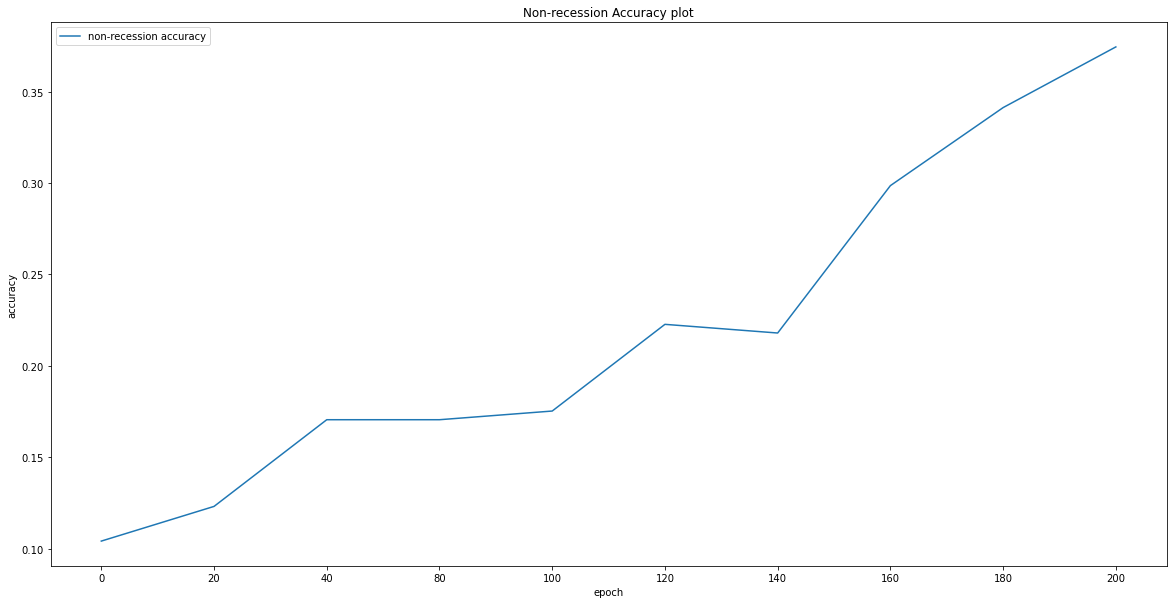

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

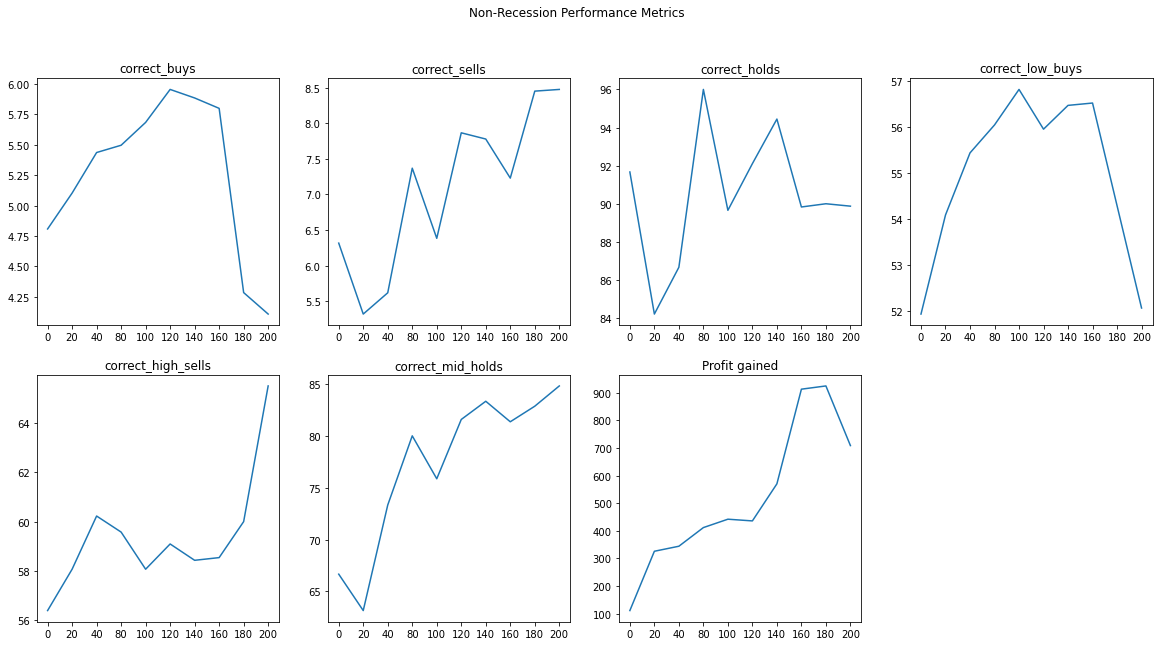

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

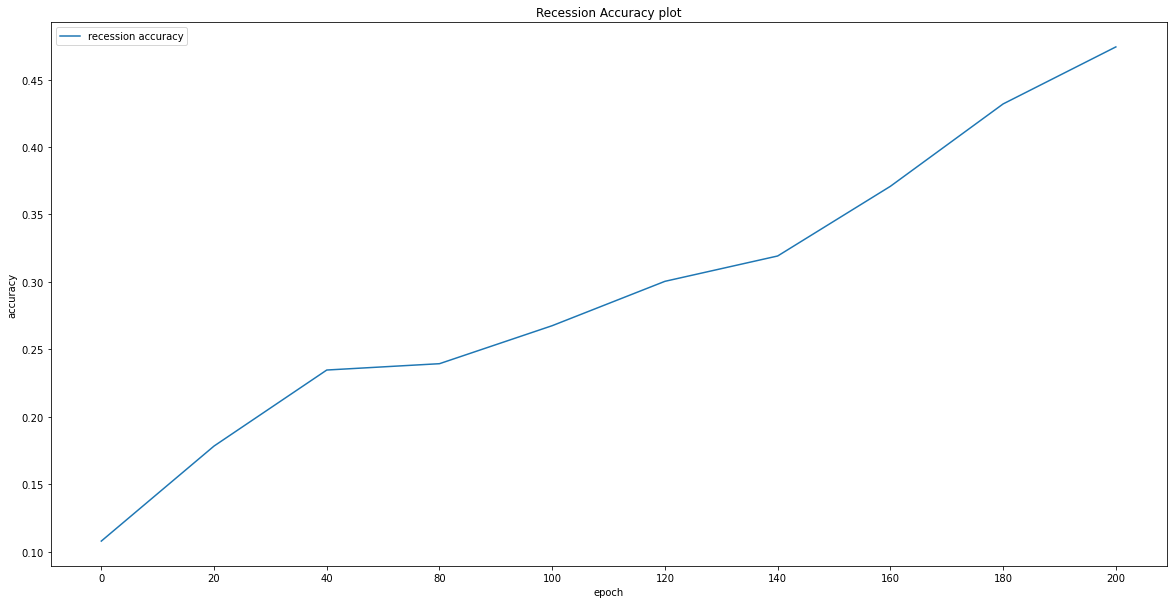

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

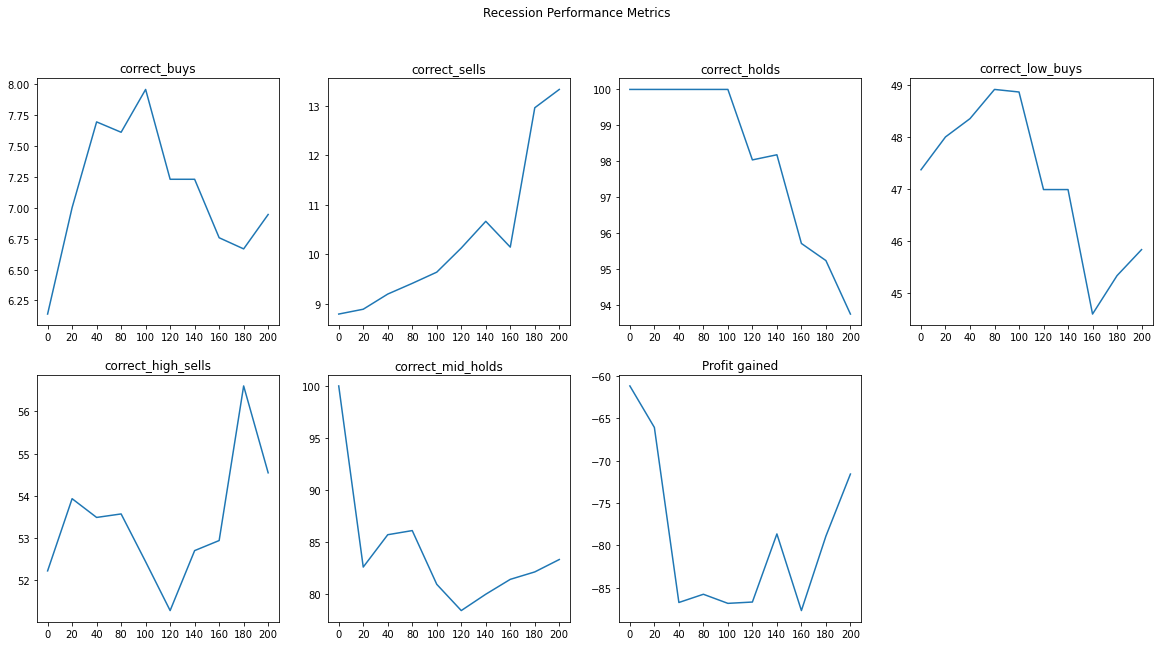

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### JP Morgan

In [47]:
nr_test_sets = ['JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [48]:
r_test_sets = ['JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


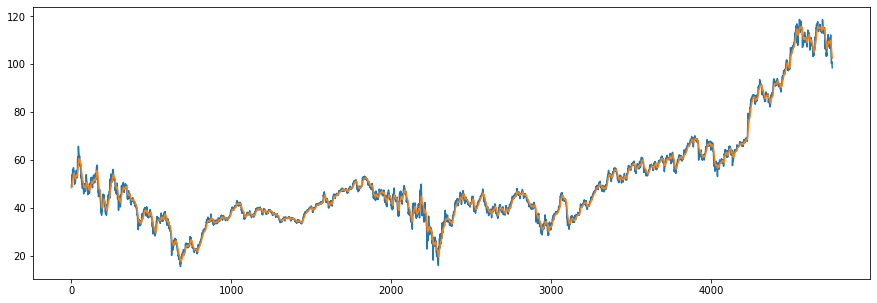

In [49]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [50]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [51]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JPM')]
    y = nr_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JPM')]
    y = r_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.715447154471545, 1: 7.3996101364522415, 2: 0.36559761148030434}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2194 - accuracy: 0.4178 - mse: 0.9905 - weighted_accuracy: 0.3397 - weighted_mse: 1.0025 - val_loss: 0.1860 - val_accuracy: 0.5385 - val_mse: 1.1773 - val_weighted_accuracy: 0.5385 - val_weighted_mse: 1.1773
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1998 - accuracy: 0.4023 - mse: 1.1687 - weighted_accuracy: 0.3784 - weighted_mse: 1.1630 - val_loss: 0.1894 - val_accuracy: 0.2392 - val_mse: 1.1416 - val_weighted_accuracy: 0.2392 - val_weighted_mse: 1.1416
Epoch 3/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1972 - accuracy: 0.3448 - mse: 1.1819 - weighted_accuracy: 0.4152 - weighted_mse: 1.1859 - val_loss: 0.1929 - val_accuracy: 0.1475 - val_mse: 1.0793 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.0793
Epoch 4/20
30/30 [==============================] - 0s 

7/7 [==============================] - 0s 6ms/step - loss: 0.1967 - accuracy: 0.2055 - mse: 1.3133 - weighted_accuracy: 0.2055 - weighted_mse: 1.3133
Test loss: 0.19673344492912292
Test accuracy: 0.2054794579744339


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 98
actual holds but predicted sell: 74
actual predicted holds: 25
Percentage buys correct: 9.25925925925926%
Percentage sells correct: 11.904761904761905%
Percentage holds correct: 92.5925925925926%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 49.532710280373834%
Percentage high sells correct: 52.38095238095238%
Percentage mid holds correct: 81.48148148148148%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price 

30/30 [==============================] - 0s 9ms/step - loss: 0.1636 - accuracy: 0.2466 - mse: 1.5010 - weighted_accuracy: 0.5684 - weighted_mse: 1.4276 - val_loss: 0.2044 - val_accuracy: 0.1665 - val_mse: 1.3922 - val_weighted_accuracy: 0.1665 - val_weighted_mse: 1.3922
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1650 - accuracy: 0.2165 - mse: 1.5140 - weighted_accuracy: 0.5782 - weighted_mse: 1.4051 - val_loss: 0.2076 - val_accuracy: 0.1528 - val_mse: 1.4680 - val_weighted_accuracy: 0.1528 - val_weighted_mse: 1.4680
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1643 - accuracy: 0.2468 - mse: 1.5238 - weighted_accuracy: 0.6049 - weighted_mse: 1.4319 - val_loss: 0.1986 - val_accuracy: 0.1897 - val_mse: 1.4798 - val_weighted_accuracy: 0.1897 - val_weighted_mse: 1.4798
Epoch 16/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1631 - accuracy: 0.2474 - mse: 1.5505 - weighted_accuracy: 0.5990 - weighted_mse: 1.469

7/7 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.1872 - mse: 1.5394 - weighted_accuracy: 0.1872 - weighted_mse: 1.5394
Test loss: 0.2043198049068451
Test accuracy: 0.18721461296081543


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 2
actual holds but predicted buy: 94
actual holds but predicted sell: 82
actual predicted holds: 21
Percentage buys correct: 9.615384615384615%
Percentage sells correct: 10.869565217391305%
Percentage holds correct: 91.30434782608695%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 51.45631067961165%
Percentage high sells correct: 53.26086956521739%
Percentage mid holds correct: 86.95652173913044%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price

30/30 [==============================] - 0s 9ms/step - loss: 0.1551 - accuracy: 0.2136 - mse: 1.6315 - weighted_accuracy: 0.6098 - weighted_mse: 1.5694 - val_loss: 0.2067 - val_accuracy: 0.1791 - val_mse: 1.5741 - val_weighted_accuracy: 0.1791 - val_weighted_mse: 1.5741
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1556 - accuracy: 0.2503 - mse: 1.6437 - weighted_accuracy: 0.6286 - weighted_mse: 1.5971 - val_loss: 0.2026 - val_accuracy: 0.1981 - val_mse: 1.5519 - val_weighted_accuracy: 0.1981 - val_weighted_mse: 1.5519
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1571 - accuracy: 0.2442 - mse: 1.6224 - weighted_accuracy: 0.6210 - weighted_mse: 1.5528 - val_loss: 0.2041 - val_accuracy: 0.1844 - val_mse: 1.5676 - val_weighted_accuracy: 0.1844 - val_weighted_mse: 1.5676
Epoch 14/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1571 - accuracy: 0.2466 - mse: 1.6232 - weighted_accuracy: 0.6027 - weighted_mse: 1.5598

7/7 [==============================] - 0s 2ms/step - loss: 0.2003 - accuracy: 0.2237 - mse: 1.6228 - weighted_accuracy: 0.2237 - weighted_mse: 1.6228
Test loss: 0.20034746825695038
Test accuracy: 0.22374428808689117


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 102
actual holds but predicted sell: 66
actual predicted holds: 29
Percentage buys correct: 8.849557522123893%
Percentage sells correct: 13.157894736842104%
Percentage holds correct: 96.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 59.21052631578947%
Percentage mid holds correct: 93.33333333333333%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase f

30/30 [==============================] - 0s 8ms/step - loss: 0.1534 - accuracy: 0.2505 - mse: 1.7342 - weighted_accuracy: 0.6328 - weighted_mse: 1.6282 - val_loss: 0.1968 - val_accuracy: 0.2403 - val_mse: 1.7012 - val_weighted_accuracy: 0.2403 - val_weighted_mse: 1.7012
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1526 - accuracy: 0.2893 - mse: 1.7323 - weighted_accuracy: 0.6335 - weighted_mse: 1.6464 - val_loss: 0.2026 - val_accuracy: 0.2076 - val_mse: 1.6923 - val_weighted_accuracy: 0.2076 - val_weighted_mse: 1.6923
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1519 - accuracy: 0.2447 - mse: 1.7395 - weighted_accuracy: 0.6248 - weighted_mse: 1.6605 - val_loss: 0.2065 - val_accuracy: 0.1802 - val_mse: 1.6972 - val_weighted_accuracy: 0.1802 - val_weighted_mse: 1.6972
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1545 - accuracy: 0.2603 - mse: 1.7360 - weighted_accuracy: 0.6267 - weighted_mse: 1.6545

0        1576.179166  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1932 - accuracy: 0.2740 - mse: 1.6449 - weighted_accuracy: 0.2740 - weighted_mse: 1.6449
Test loss: 0.1932421177625656
Test accuracy: 0.27397260069847107


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 101
actual holds but predicted sell: 56
actual predicted holds: 40
Percentage buys correct: 8.928571428571429%
Percentage sells correct: 15.151515151515152%
Percentage holds correct: 97.5609756097561%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.450450450450454%
Percentage high sells correct: 60.60606060606061%
Percentage mid holds correct: 95.1219512195122%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capita

30/30 [==============================] - 0s 8ms/step - loss: 0.1495 - accuracy: 0.3232 - mse: 1.7818 - weighted_accuracy: 0.6363 - weighted_mse: 1.7497 - val_loss: 0.2024 - val_accuracy: 0.2234 - val_mse: 1.6772 - val_weighted_accuracy: 0.2234 - val_weighted_mse: 1.6772
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1484 - accuracy: 0.2935 - mse: 1.8182 - weighted_accuracy: 0.6541 - weighted_mse: 1.7565 - val_loss: 0.1989 - val_accuracy: 0.2645 - val_mse: 1.7599 - val_weighted_accuracy: 0.2645 - val_weighted_mse: 1.7599
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1486 - accuracy: 0.2879 - mse: 1.8160 - weighted_accuracy: 0.6578 - weighted_mse: 1.7313 - val_loss: 0.2020 - val_accuracy: 0.2381 - val_mse: 1.7620 - val_weighted_accuracy: 0.2381 - val_weighted_mse: 1.7620
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1474 - accuracy: 0.2877 - mse: 1.8335 - weighted_accuracy: 0.6498 - weighted_mse: 1.7623

0        1576.179166  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1966 - accuracy: 0.2740 - mse: 1.7147 - weighted_accuracy: 0.2740 - weighted_mse: 1.7147
Test loss: 0.19663266837596893
Test accuracy: 0.27397260069847107


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 97
actual holds but predicted sell: 60
actual predicted holds: 40
Percentage buys correct: 9.25925925925926%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 97.5609756097561%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.467289719626166%
Percentage high sells correct: 61.42857142857143%
Percentage mid holds correct: 95.1219512195122%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital

30/30 [==============================] - 0s 9ms/step - loss: 0.1424 - accuracy: 0.2850 - mse: 1.9086 - weighted_accuracy: 0.6779 - weighted_mse: 1.8788 - val_loss: 0.1922 - val_accuracy: 0.3035 - val_mse: 1.8579 - val_weighted_accuracy: 0.3035 - val_weighted_mse: 1.8579
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1456 - accuracy: 0.3248 - mse: 1.8909 - weighted_accuracy: 0.6601 - weighted_mse: 1.8135 - val_loss: 0.1985 - val_accuracy: 0.2677 - val_mse: 1.8889 - val_weighted_accuracy: 0.2677 - val_weighted_mse: 1.8889
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1418 - accuracy: 0.2974 - mse: 1.9539 - weighted_accuracy: 0.6726 - weighted_mse: 1.8845 - val_loss: 0.2034 - val_accuracy: 0.2445 - val_mse: 1.8155 - val_weighted_accuracy: 0.2445 - val_weighted_mse: 1.8155
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1412 - accuracy: 0.3253 - mse: 1.9564 - weighted_accuracy: 0.6928 - weighted_mse: 1.9126

7/7 [==============================] - 0s 2ms/step - loss: 0.1887 - accuracy: 0.3516 - mse: 1.8175 - weighted_accuracy: 0.3516 - weighted_mse: 1.8175
Test loss: 0.1887400597333908
Test accuracy: 0.35159817337989807


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 90
actual holds but predicted sell: 49
actual predicted holds: 58
Percentage buys correct: 9.900990099009901%
Percentage sells correct: 15.517241379310345%
Percentage holds correct: 96.66666666666667%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 50.0%
Percentage high sells correct: 63.793103448275865%
Percentage mid holds correct: 88.33333333333333%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Price increase f

30/30 [==============================] - 0s 9ms/step - loss: 0.1344 - accuracy: 0.3670 - mse: 2.1257 - weighted_accuracy: 0.7196 - weighted_mse: 2.0999 - val_loss: 0.1773 - val_accuracy: 0.3994 - val_mse: 2.0088 - val_weighted_accuracy: 0.3994 - val_weighted_mse: 2.0088
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1372 - accuracy: 0.3628 - mse: 2.0188 - weighted_accuracy: 0.6987 - weighted_mse: 1.9914 - val_loss: 0.1962 - val_accuracy: 0.3035 - val_mse: 2.0233 - val_weighted_accuracy: 0.3035 - val_weighted_mse: 2.0233
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1349 - accuracy: 0.3541 - mse: 2.1235 - weighted_accuracy: 0.7125 - weighted_mse: 2.1025 - val_loss: 0.1954 - val_accuracy: 0.3098 - val_mse: 1.9524 - val_weighted_accuracy: 0.3098 - val_weighted_mse: 1.9524
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1355 - accuracy: 0.3778 - mse: 2.1503 - weighted_accuracy: 0.7059 - weighted_mse: 2.1374

7/7 [==============================] - 0s 2ms/step - loss: 0.1848 - accuracy: 0.3653 - mse: 1.9717 - weighted_accuracy: 0.3653 - weighted_mse: 1.9717
Test loss: 0.18475370109081268
Test accuracy: 0.3652968108654022


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 86
actual holds but predicted sell: 48
actual predicted holds: 63
Percentage buys correct: 10.309278350515465%
Percentage sells correct: 12.727272727272727%
Percentage holds correct: 94.02985074626865%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 48.958333333333336%
Percentage high sells correct: 61.81818181818182%
Percentage mid holds correct: 86.56716417910448%


Capital: 100
Share price: $0.9699796411480657
Shares owned at the moment: 102
Cash capital at the moment: $0.7899973135552756


Pr

30/30 [==============================] - 0s 8ms/step - loss: 0.1310 - accuracy: 0.3685 - mse: 2.1687 - weighted_accuracy: 0.7217 - weighted_mse: 2.1922 - val_loss: 0.1750 - val_accuracy: 0.4257 - val_mse: 2.1341 - val_weighted_accuracy: 0.4257 - val_weighted_mse: 2.1341
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1320 - accuracy: 0.3862 - mse: 2.1835 - weighted_accuracy: 0.7298 - weighted_mse: 2.2209 - val_loss: 0.1943 - val_accuracy: 0.3361 - val_mse: 2.0830 - val_weighted_accuracy: 0.3361 - val_weighted_mse: 2.0830
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1300 - accuracy: 0.4028 - mse: 2.1919 - weighted_accuracy: 0.7263 - weighted_mse: 2.2416 - val_loss: 0.1921 - val_accuracy: 0.3446 - val_mse: 2.1465 - val_weighted_accuracy: 0.3446 - val_weighted_mse: 2.1465
Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1306 - accuracy: 0.4078 - mse: 2.2665 - weighted_accuracy: 0.7435 - weighted_mse: 2.2890

7/7 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.3927 - mse: 2.1226 - weighted_accuracy: 0.3927 - weighted_mse: 2.1226
Test loss: 0.18123577535152435
Test accuracy: 0.39269405603408813


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 77
actual holds but predicted sell: 48
actual predicted holds: 72
Percentage buys correct: 9.411764705882353%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 47.61904761904762%
Percentage high sells correct: 57.407407407407405%
Percentage mid holds correct: 83.75%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price increase from previously 

30/30 [==============================] - 0s 8ms/step - loss: 0.1261 - accuracy: 0.4457 - mse: 2.3164 - weighted_accuracy: 0.7424 - weighted_mse: 2.3989 - val_loss: 0.2014 - val_accuracy: 0.3193 - val_mse: 2.2953 - val_weighted_accuracy: 0.3193 - val_weighted_mse: 2.2953
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1237 - accuracy: 0.4283 - mse: 2.3825 - weighted_accuracy: 0.7512 - weighted_mse: 2.5006 - val_loss: 0.1696 - val_accuracy: 0.4563 - val_mse: 2.2555 - val_weighted_accuracy: 0.4563 - val_weighted_mse: 2.2555
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1262 - accuracy: 0.4405 - mse: 2.3047 - weighted_accuracy: 0.7383 - weighted_mse: 2.3612 - val_loss: 0.1900 - val_accuracy: 0.3667 - val_mse: 2.2363 - val_weighted_accuracy: 0.3667 - val_weighted_mse: 2.2363
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1242 - accuracy: 0.4410 - mse: 2.3636 - weighted_accuracy: 0.7519 - weighted_mse: 2.4600 

7/7 [==============================] - 0s 2ms/step - loss: 0.1796 - accuracy: 0.4201 - mse: 2.2747 - weighted_accuracy: 0.4201 - weighted_mse: 2.2747
Test loss: 0.17958195507526398
Test accuracy: 0.42009133100509644


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 67
actual holds but predicted sell: 48
actual predicted holds: 82
Percentage buys correct: 5.633802816901408%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 87.23404255319149%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 42.857142857142854%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 80.85106382978724%


Capital: 100
Share price: $1.001351628009516
Shares owned at the moment: 99
Cash capital at the moment: $0.5935708463323124


Price 

30/30 [==============================] - 0s 8ms/step - loss: 0.1191 - accuracy: 0.4839 - mse: 2.5353 - weighted_accuracy: 0.7808 - weighted_mse: 2.6363 - val_loss: 0.1953 - val_accuracy: 0.3730 - val_mse: 2.4409 - val_weighted_accuracy: 0.3730 - val_weighted_mse: 2.4409
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1195 - accuracy: 0.4673 - mse: 2.5627 - weighted_accuracy: 0.7579 - weighted_mse: 2.6604 - val_loss: 0.1728 - val_accuracy: 0.4689 - val_mse: 2.4101 - val_weighted_accuracy: 0.4689 - val_weighted_mse: 2.4101
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1208 - accuracy: 0.4860 - mse: 2.4442 - weighted_accuracy: 0.7649 - weighted_mse: 2.5404 - val_loss: 0.1866 - val_accuracy: 0.4131 - val_mse: 2.3789 - val_weighted_accuracy: 0.4131 - val_weighted_mse: 2.3789
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1175 - accuracy: 0.4889 - mse: 2.5294 - weighted_accuracy: 0.7828 - weighted_mse: 2.6467 

   Test_accuracy  correct_buys  correct_sells  correct_holds  \
0       0.366972     10.465116       6.451613      95.714286   

   correct_low_buys  correct_high_sells  correct_mid_holds  Profit gained  \
0         52.325581           50.819672               90.0    1172.864115   

   buy_n_hold profit  
0        1576.179166  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1915 - accuracy: 0.3836 - mse: 2.4010 - weighted_accuracy: 0.3836 - weighted_mse: 2.4010
Test loss: 0.191452294588089
Test accuracy: 0.3835616409778595


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 77
actual holds but predicted sell: 48
actual predicted holds: 72
Percentage buys correct: 7.228915662650603%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 87.80487

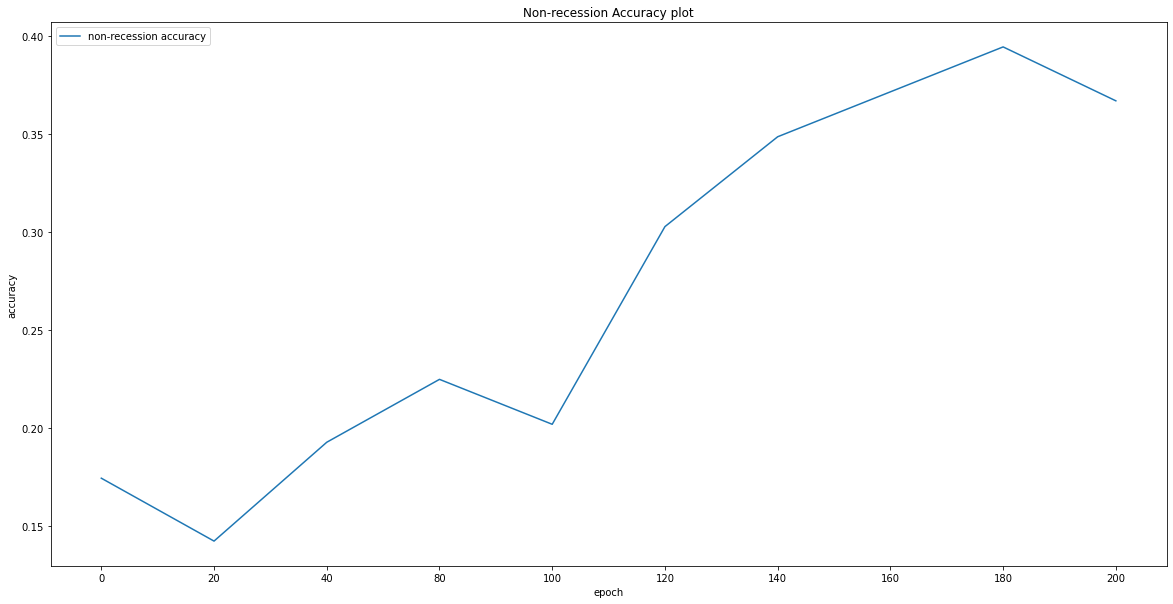

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

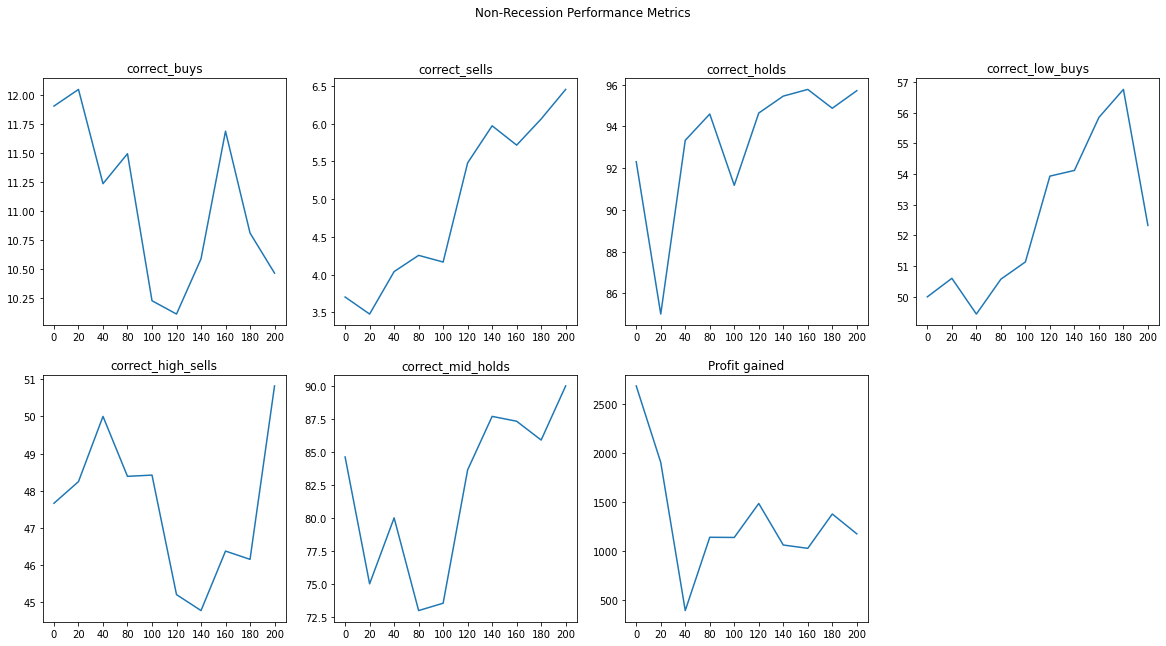

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

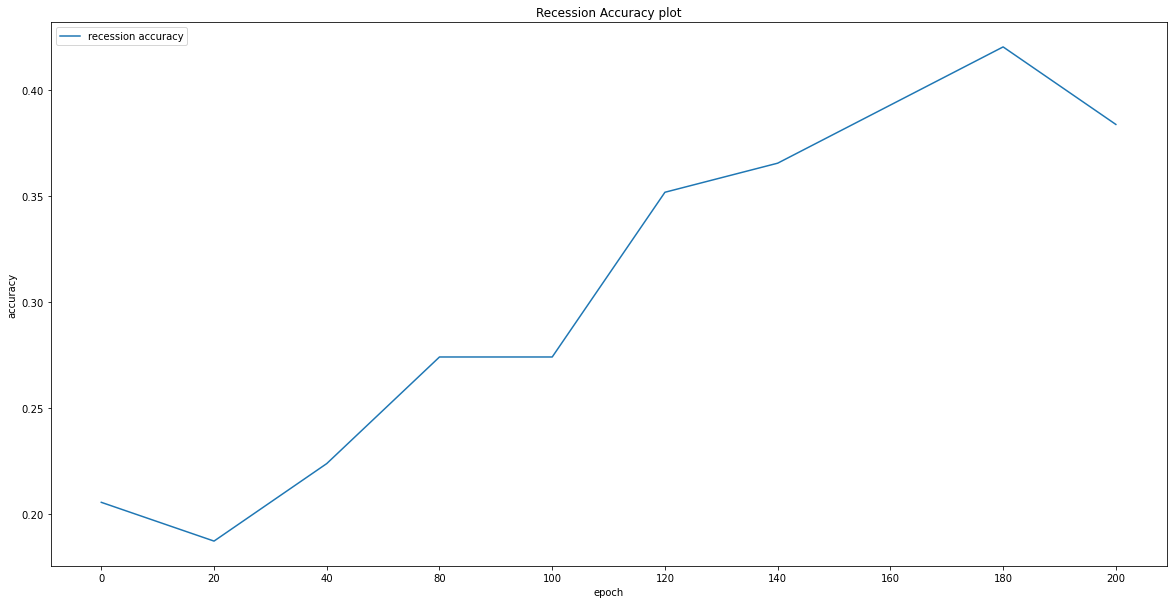

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

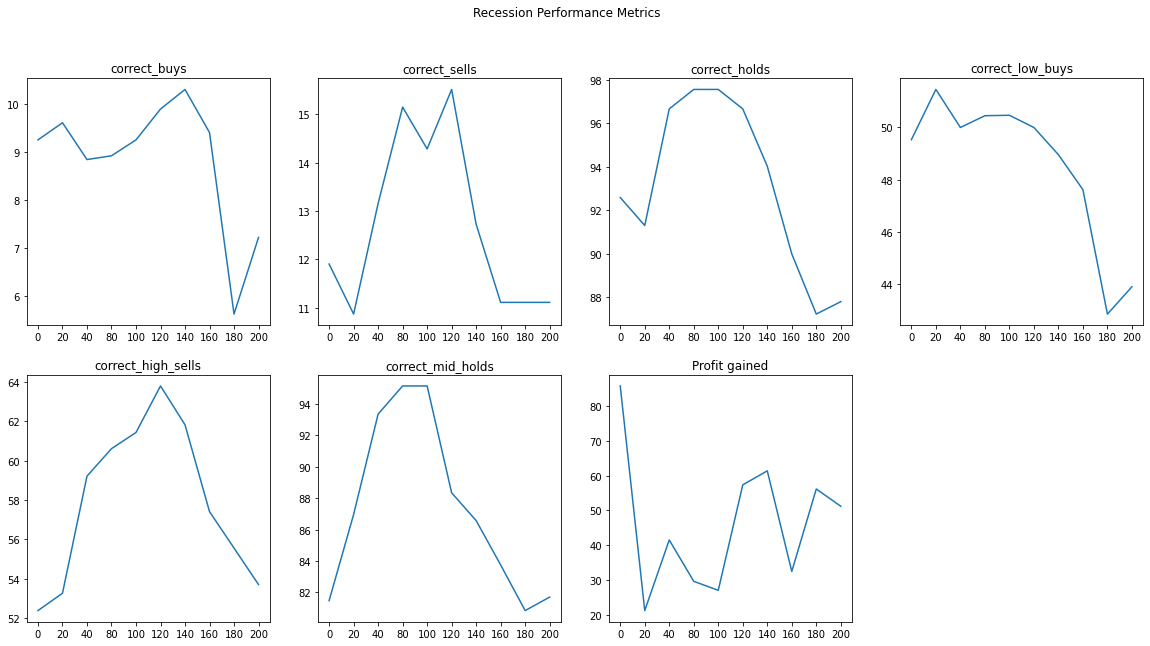

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### American Axle

In [59]:
nr_test_sets = ['AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [60]:
r_test_sets = ['AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
    seq_new = []
    data_15 = []
    for i in range(0,len(sequential)):
        for j in range(0,len(sequential[i])):
            x = sequential[i][j]
            a = np.zeros(60)
            data_15.append(np.concatenate((x, a)))

        for j in range(1,50):
            x = np.zeros(64)
            data_15.append(x)
        seq_new.append(data_15)
        data_15 = []
        
    X = np.array(seq_new).reshape(-1, 64, 64, 1)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


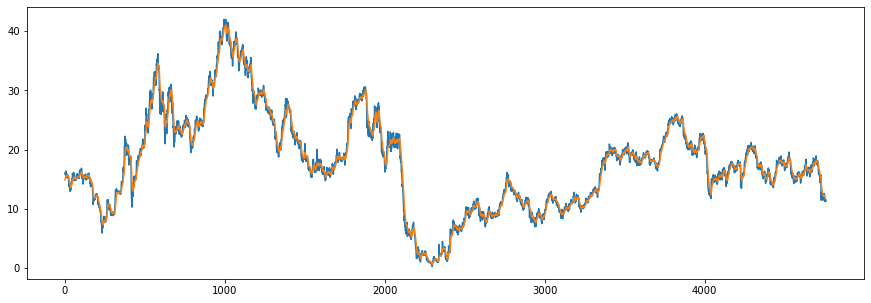

In [61]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/AXL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
seq_new = []
data_15 = []
for i in range(0,len(sequential)):
    for j in range(0,len(sequential[i])):
        x = sequential[i][j]
        a = np.zeros(60)
        data_15.append(np.concatenate((x, a)))
        
    for j in range(1,50):
        x = np.zeros(64)
        data_15.append(x)
    seq_new.append(data_15)
    data_15 = []
    
X = np.array(seq_new).reshape(-1, 64, 64, 1)
y = labels
y = np.array(y)

In [62]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [63]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [64]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import efficientnet.tfkeras as efn
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform',kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2), padding='valid'))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

# model.add(Dense(128, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))
# model.add(Dropout(0.25, seed=seed))

model.add(Dense(64, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(32, kernel_initializer='he_uniform', kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))
model.add(Dropout(0.25, seed=seed))

model.add(Dense(3, use_bias=True, activation=None))

In [66]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('AXL')]
    y = nr_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('AXL')]
    y = r_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df = df.iloc[14:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.272030651340996, 1: 7.3140655105973025, 2: 0.36686962404561707}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 0s 16ms/step - loss: 0.2213 - accuracy: 0.4594 - mse: 0.9799 - weighted_accuracy: 0.3478 - weighted_mse: 1.0199 - val_loss: 0.1855 - val_accuracy: 0.2339 - val_mse: 1.1983 - val_weighted_accuracy: 0.2339 - val_weighted_mse: 1.1983
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2029 - accuracy: 0.3786 - mse: 1.1364 - weighted_accuracy: 0.3707 - weighted_mse: 1.1537 - val_loss: 0.1893 - val_accuracy: 0.3509 - val_mse: 1.0852 - val_weighted_accuracy: 0.3509 - val_weighted_mse: 1.0852
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2008 - accuracy: 0.3053 - mse: 1.1851 - weighted_accuracy: 0.3875 - weighted_mse: 1.1861 - val_loss: 0.1943 - val_accuracy: 0.0906 - val_mse: 1.0680 - val_weighted_accuracy: 0.0906 - val_weighted_mse: 1.0680
Epoch 4/20
30/30 [==============================] - 0s 

7/7 [==============================] - 0s 2ms/step - loss: 0.2023 - accuracy: 0.1233 - mse: 1.2669 - weighted_accuracy: 0.1233 - weighted_mse: 1.2669
Test loss: 0.20231153070926666
Test accuracy: 0.12328767031431198


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 95
actual holds but predicted sell: 93
actual predicted holds: 9
Percentage buys correct: 10.185185185185185%
Percentage sells correct: 7.0%
Percentage holds correct: 81.81818181818181%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 52.33644859813084%
Percentage high sells correct: 60.0%
Percentage mid holds correct: 72.72727272727273%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price increase from previously bo

30/30 [==============================] - 0s 9ms/step - loss: 0.1710 - accuracy: 0.2237 - mse: 1.4080 - weighted_accuracy: 0.5565 - weighted_mse: 1.3247 - val_loss: 0.1997 - val_accuracy: 0.1633 - val_mse: 1.3593 - val_weighted_accuracy: 0.1633 - val_weighted_mse: 1.3593
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1688 - accuracy: 0.2210 - mse: 1.4288 - weighted_accuracy: 0.5774 - weighted_mse: 1.3373 - val_loss: 0.2072 - val_accuracy: 0.1254 - val_mse: 1.3395 - val_weighted_accuracy: 0.1254 - val_weighted_mse: 1.3395
Epoch 9/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1683 - accuracy: 0.1981 - mse: 1.4584 - weighted_accuracy: 0.5800 - weighted_mse: 1.3538 - val_loss: 0.2048 - val_accuracy: 0.1475 - val_mse: 1.3788 - val_weighted_accuracy: 0.1475 - val_weighted_mse: 1.3788
Epoch 10/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1677 - accuracy: 0.2308 - mse: 1.4320 - weighted_accuracy: 0.5900 - weighted_mse: 1.3399 -

7/7 [==============================] - 0s 2ms/step - loss: 0.2022 - accuracy: 0.1553 - mse: 1.4248 - weighted_accuracy: 0.1553 - weighted_mse: 1.4248
Test loss: 0.20222939550876617
Test accuracy: 0.155251145362854


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 89
actual holds but predicted sell: 93
actual predicted holds: 15
Percentage buys correct: 10.891089108910892%
Percentage sells correct: 7.920792079207921%
Percentage holds correct: 88.23529411764706%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 56.0%
Percentage high sells correct: 58.415841584158414%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price increase from 

30/30 [==============================] - 0s 8ms/step - loss: 0.1608 - accuracy: 0.2405 - mse: 1.5610 - weighted_accuracy: 0.6045 - weighted_mse: 1.4430 - val_loss: 0.2043 - val_accuracy: 0.1802 - val_mse: 1.5268 - val_weighted_accuracy: 0.1802 - val_weighted_mse: 1.5268
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1610 - accuracy: 0.2210 - mse: 1.5822 - weighted_accuracy: 0.6029 - weighted_mse: 1.4505 - val_loss: 0.2034 - val_accuracy: 0.1855 - val_mse: 1.4970 - val_weighted_accuracy: 0.1855 - val_weighted_mse: 1.4970
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1600 - accuracy: 0.2376 - mse: 1.5504 - weighted_accuracy: 0.6163 - weighted_mse: 1.4537 - val_loss: 0.1993 - val_accuracy: 0.2034 - val_mse: 1.4820 - val_weighted_accuracy: 0.2034 - val_weighted_mse: 1.4820
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1612 - accuracy: 0.2429 - mse: 1.5225 - weighted_accuracy: 0.6037 - weighted_mse: 1.4330 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1974 - accuracy: 0.2009 - mse: 1.5403 - weighted_accuracy: 0.2009 - weighted_mse: 1.5403
Test loss: 0.19743026793003082
Test accuracy: 0.2009132355451584


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 2
actual holds but predicted buy: 91
actual holds but predicted sell: 81
actual predicted holds: 25
Percentage buys correct: 10.679611650485437%
Percentage sells correct: 8.98876404494382%
Percentage holds correct: 92.5925925925926%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.90196078431372%
Percentage high sells correct: 64.04494382022472%
Percentage mid holds correct: 85.18518518518519%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price in

30/30 [==============================] - 0s 8ms/step - loss: 0.1574 - accuracy: 0.2189 - mse: 1.6369 - weighted_accuracy: 0.6258 - weighted_mse: 1.5441 - val_loss: 0.2024 - val_accuracy: 0.1970 - val_mse: 1.6238 - val_weighted_accuracy: 0.1970 - val_weighted_mse: 1.6238
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1563 - accuracy: 0.2297 - mse: 1.6670 - weighted_accuracy: 0.6243 - weighted_mse: 1.5692 - val_loss: 0.1985 - val_accuracy: 0.2350 - val_mse: 1.6018 - val_weighted_accuracy: 0.2350 - val_weighted_mse: 1.6018
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1554 - accuracy: 0.2753 - mse: 1.6425 - weighted_accuracy: 0.6320 - weighted_mse: 1.5820 - val_loss: 0.1974 - val_accuracy: 0.2381 - val_mse: 1.6154 - val_weighted_accuracy: 0.2381 - val_weighted_mse: 1.6154
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1571 - accuracy: 0.2653 - mse: 1.6446 - weighted_accuracy: 0.6210 - weighted_mse: 1.5345 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1961 - accuracy: 0.2100 - mse: 1.5701 - weighted_accuracy: 0.2100 - weighted_mse: 1.5701
Test loss: 0.19608893990516663
Test accuracy: 0.21004566550254822


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 90
actual holds but predicted sell: 79
actual predicted holds: 28
Percentage buys correct: 10.784313725490197%
Percentage sells correct: 8.13953488372093%
Percentage holds correct: 90.3225806451613%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.445544554455445%
Percentage high sells correct: 65.11627906976744%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price 

30/30 [==============================] - 0s 9ms/step - loss: 0.1517 - accuracy: 0.2674 - mse: 1.7437 - weighted_accuracy: 0.6290 - weighted_mse: 1.6879 - val_loss: 0.2063 - val_accuracy: 0.1992 - val_mse: 1.6470 - val_weighted_accuracy: 0.1992 - val_weighted_mse: 1.6470
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1509 - accuracy: 0.2561 - mse: 1.8121 - weighted_accuracy: 0.6541 - weighted_mse: 1.6990 - val_loss: 0.1968 - val_accuracy: 0.2445 - val_mse: 1.7382 - val_weighted_accuracy: 0.2445 - val_weighted_mse: 1.7382
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1517 - accuracy: 0.2837 - mse: 1.7108 - weighted_accuracy: 0.6277 - weighted_mse: 1.6438 - val_loss: 0.1962 - val_accuracy: 0.2487 - val_mse: 1.6486 - val_weighted_accuracy: 0.2487 - val_weighted_mse: 1.6486
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1516 - accuracy: 0.2798 - mse: 1.7270 - weighted_accuracy: 0.6464 - weighted_mse: 1.6640 - 

7/7 [==============================] - 0s 2ms/step - loss: 0.1968 - accuracy: 0.2283 - mse: 1.6918 - weighted_accuracy: 0.2283 - weighted_mse: 1.6918
Test loss: 0.1968427449464798
Test accuracy: 0.2283104956150055


number of predictions: 219
actual predicted buys: 11
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 86
actual holds but predicted sell: 81
actual predicted holds: 30
Percentage buys correct: 11.224489795918368%
Percentage sells correct: 10.0%
Percentage holds correct: 96.7741935483871%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.670103092783506%
Percentage high sells correct: 63.333333333333336%
Percentage mid holds correct: 90.3225806451613%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price increase from 

30/30 [==============================] - 0s 9ms/step - loss: 0.1477 - accuracy: 0.2821 - mse: 1.8070 - weighted_accuracy: 0.6545 - weighted_mse: 1.7144 - val_loss: 0.2043 - val_accuracy: 0.2129 - val_mse: 1.7781 - val_weighted_accuracy: 0.2129 - val_weighted_mse: 1.7781
Epoch 6/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1459 - accuracy: 0.2563 - mse: 1.8730 - weighted_accuracy: 0.6688 - weighted_mse: 1.8057 - val_loss: 0.1994 - val_accuracy: 0.2466 - val_mse: 1.7559 - val_weighted_accuracy: 0.2466 - val_weighted_mse: 1.7559
Epoch 7/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1464 - accuracy: 0.3003 - mse: 1.8094 - weighted_accuracy: 0.6795 - weighted_mse: 1.7420 - val_loss: 0.1940 - val_accuracy: 0.2719 - val_mse: 1.7927 - val_weighted_accuracy: 0.2719 - val_weighted_mse: 1.7927
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1459 - accuracy: 0.3056 - mse: 1.8195 - weighted_accuracy: 0.6631 - weighted_mse: 1.7759 - 

0           -40.1962  


Recession Test


7/7 [==============================] - 0s 2ms/step - loss: 0.1923 - accuracy: 0.2603 - mse: 1.7418 - weighted_accuracy: 0.2603 - weighted_mse: 1.7418
Test loss: 0.19229179620742798
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 10
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 84
actual holds but predicted sell: 75
actual predicted holds: 38
Percentage buys correct: 10.526315789473685%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 95.0%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.319148936170215%
Percentage high sells correct: 63.095238095238095%
Percentage mid holds correct: 90.0%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.58525

30/30 [==============================] - 0s 9ms/step - loss: 0.1436 - accuracy: 0.3040 - mse: 1.8788 - weighted_accuracy: 0.6772 - weighted_mse: 1.8167 - val_loss: 0.2004 - val_accuracy: 0.2466 - val_mse: 1.8889 - val_weighted_accuracy: 0.2466 - val_weighted_mse: 1.8889
Epoch 8/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1422 - accuracy: 0.3032 - mse: 1.9155 - weighted_accuracy: 0.6842 - weighted_mse: 1.8770 - val_loss: 0.2023 - val_accuracy: 0.2540 - val_mse: 1.8946 - val_weighted_accuracy: 0.2540 - val_weighted_mse: 1.8946
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1408 - accuracy: 0.3006 - mse: 1.9918 - weighted_accuracy: 0.6978 - weighted_mse: 1.9374 - val_loss: 0.1971 - val_accuracy: 0.2824 - val_mse: 1.9264 - val_weighted_accuracy: 0.2824 - val_weighted_mse: 1.9264
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1427 - accuracy: 0.3219 - mse: 1.8926 - weighted_accuracy: 0.6746 - weighted_mse: 1.8530 -

7/7 [==============================] - 0s 2ms/step - loss: 0.1936 - accuracy: 0.2648 - mse: 1.8698 - weighted_accuracy: 0.2648 - weighted_mse: 1.8698
Test loss: 0.19359849393367767
Test accuracy: 0.26484018564224243


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 84
actual holds but predicted sell: 71
actual predicted holds: 42
Percentage buys correct: 9.574468085106384%
Percentage sells correct: 8.974358974358974%
Percentage holds correct: 89.36170212765957%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.83870967741935%
Percentage high sells correct: 65.38461538461539%
Percentage mid holds correct: 87.23404255319149%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price i

Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1382 - accuracy: 0.3535 - mse: 1.9920 - weighted_accuracy: 0.6953 - weighted_mse: 2.0033 - val_loss: 0.1987 - val_accuracy: 0.2877 - val_mse: 1.9316 - val_weighted_accuracy: 0.2877 - val_weighted_mse: 1.9316
Epoch 8/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1357 - accuracy: 0.3728 - mse: 1.9681 - weighted_accuracy: 0.7206 - weighted_mse: 1.9651 - val_loss: 0.1981 - val_accuracy: 0.3024 - val_mse: 2.0587 - val_weighted_accuracy: 0.3024 - val_weighted_mse: 2.0587
Epoch 9/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1376 - accuracy: 0.3156 - mse: 2.0795 - weighted_accuracy: 0.6960 - weighted_mse: 2.0702 - val_loss: 0.1948 - val_accuracy: 0.3161 - val_mse: 1.9366 - val_weighted_accuracy: 0.3161 - val_weighted_mse: 1.9366
Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1374 - accuracy: 0.3754 - mse: 2.0436 - weighted_accuracy: 0.7033 - weighted_ms

7/7 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.3790 - mse: 2.0265 - weighted_accuracy: 0.3790 - weighted_mse: 2.0265
Test loss: 0.18584032356739044
Test accuracy: 0.37899544835090637


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 65
actual holds but predicted sell: 64
actual predicted holds: 68
Percentage buys correct: 10.81081081081081%
Percentage sells correct: 9.859154929577464%
Percentage holds correct: 91.89189189189189%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 52.054794520547944%
Percentage high sells correct: 66.19718309859155%
Percentage mid holds correct: 87.83783783783784%


Capital: 100
Share price: $0.944210527554113
Shares owned at the moment: 105
Cash capital at the moment: $0.585253816986878


Price 

Epoch 10/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1310 - accuracy: 0.4112 - mse: 2.2293 - weighted_accuracy: 0.7366 - weighted_mse: 2.2663 - val_loss: 0.2048 - val_accuracy: 0.3066 - val_mse: 2.1568 - val_weighted_accuracy: 0.3066 - val_weighted_mse: 2.1568
Epoch 11/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1310 - accuracy: 0.3604 - mse: 2.1792 - weighted_accuracy: 0.7270 - weighted_mse: 2.1971 - val_loss: 0.1868 - val_accuracy: 0.3899 - val_mse: 2.1739 - val_weighted_accuracy: 0.3899 - val_weighted_mse: 2.1739
Epoch 12/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1321 - accuracy: 0.4128 - mse: 2.1573 - weighted_accuracy: 0.7299 - weighted_mse: 2.2153 - val_loss: 0.1960 - val_accuracy: 0.3467 - val_mse: 2.1365 - val_weighted_accuracy: 0.3467 - val_weighted_mse: 2.1365
Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1305 - accuracy: 0.3836 - mse: 2.2140 - weighted_accuracy: 0.7264 - weighted

7/7 [==============================] - 0s 2ms/step - loss: 0.1885 - accuracy: 0.3927 - mse: 2.0347 - weighted_accuracy: 0.3927 - weighted_mse: 2.0347
Test loss: 0.1885204017162323
Test accuracy: 0.39269405603408813


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 66
actual holds but predicted sell: 59
actual predicted holds: 72
Percentage buys correct: 10.666666666666666%
Percentage sells correct: 9.23076923076923%
Percentage holds correct: 91.13924050632912%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.054054054054056%
Percentage high sells correct: 64.61538461538461%
Percentage mid holds correct: 88.60759493670886%


Capital: 100
Share price: $0.7376316242287357
Shares owned at the moment: 135
Cash capital at the moment: $0.1458849886257525


Price

Epoch 12/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 0.4410 - mse: 2.2896 - weighted_accuracy: 0.7493 - weighted_mse: 2.4535 - val_loss: 0.1936 - val_accuracy: 0.3667 - val_mse: 2.1993 - val_weighted_accuracy: 0.3667 - val_weighted_mse: 2.1993
Epoch 13/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1251 - accuracy: 0.4312 - mse: 2.3309 - weighted_accuracy: 0.7439 - weighted_mse: 2.4144 - val_loss: 0.1885 - val_accuracy: 0.4057 - val_mse: 2.2621 - val_weighted_accuracy: 0.4057 - val_weighted_mse: 2.2621
Epoch 14/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 0.4420 - mse: 2.2780 - weighted_accuracy: 0.7460 - weighted_mse: 2.4073 - val_loss: 0.1972 - val_accuracy: 0.3688 - val_mse: 2.3167 - val_weighted_accuracy: 0.3688 - val_weighted_mse: 2.3167
Epoch 15/20
30/30 [==============================] - 0s 8ms/step - loss: 0.1260 - accuracy: 0.4349 - mse: 2.4191 - weighted_accuracy: 0.7380 - weighted

0          -32.50977  


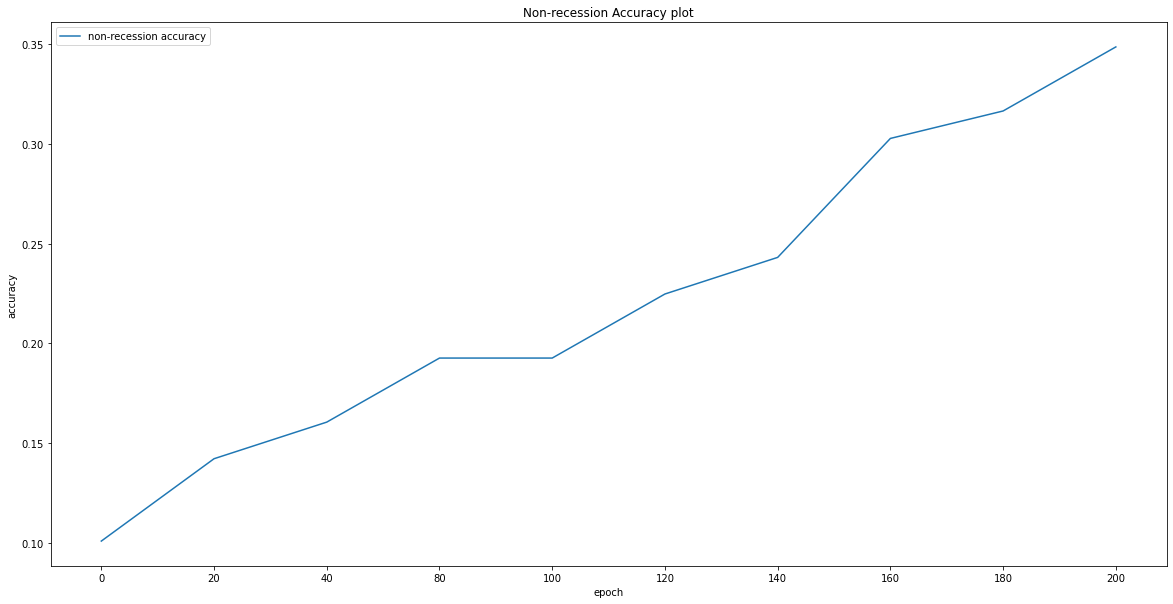

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

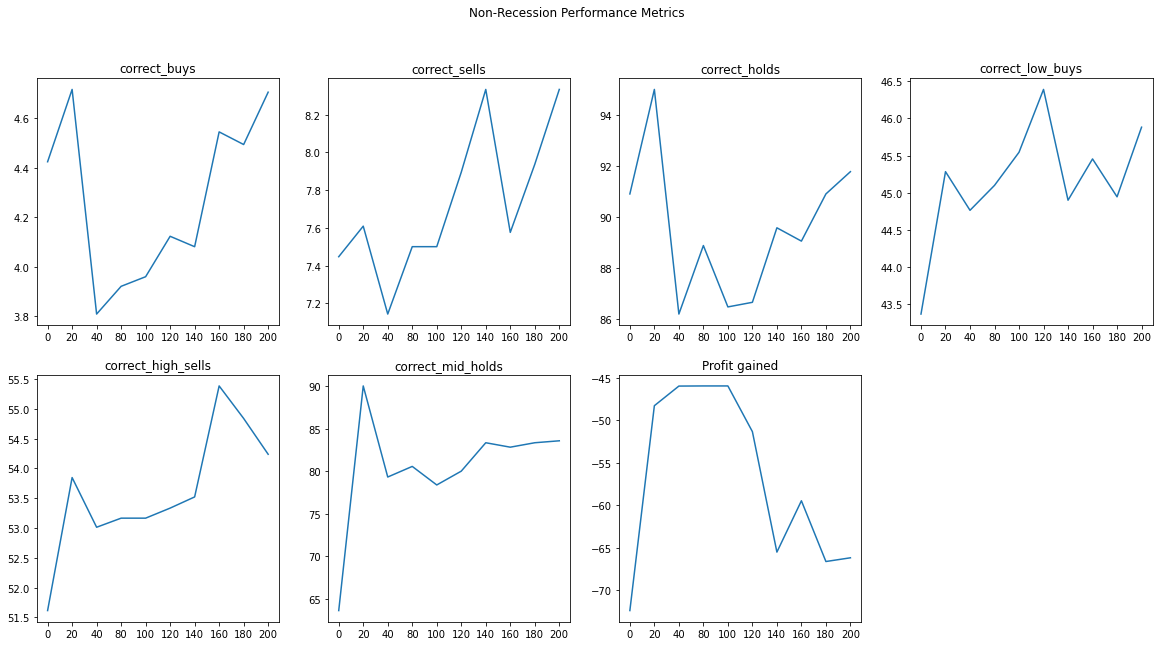

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

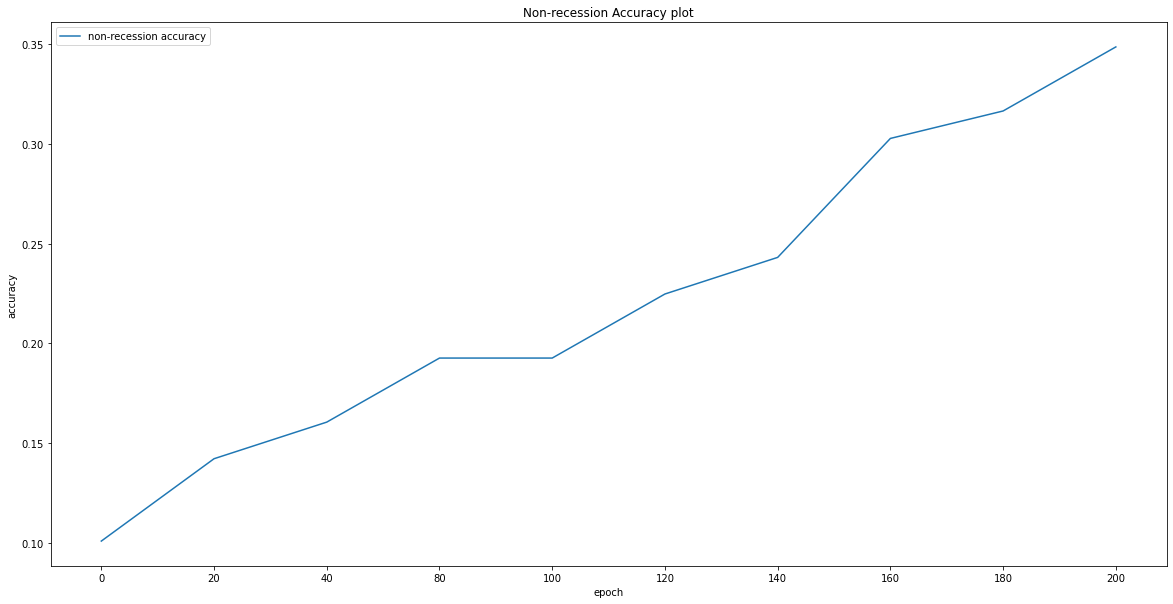

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

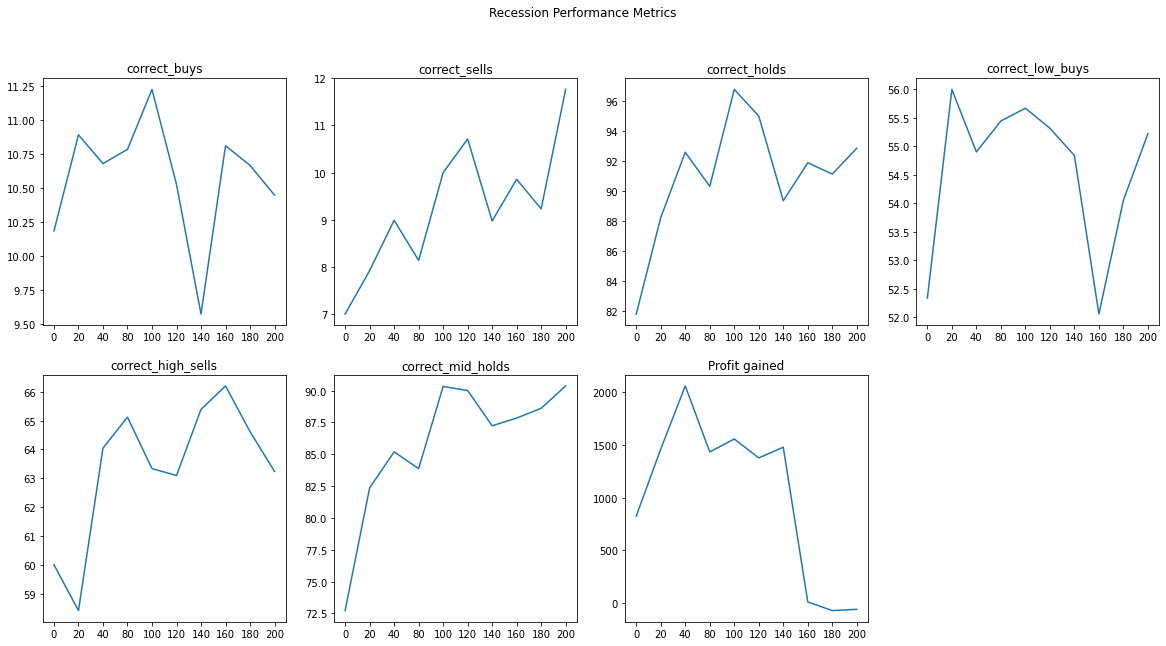

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")